In [1]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# representation of model layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import joblib
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

2025-04-21 07:03:14.175382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745218994.357635      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745218994.412191      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **ĐỌC DỮ LIỆU**

📌 Nhãn Attack: Thêm 234,021 dòng, tổng cộng 234,021 dòng
📌 Nhãn Benign: Thêm 5,645 dòng, tổng cộng 5,645 dòng
📌 File 0: Giữ 239,666 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 236,587 dòng, tổng cộng 470,608 dòng
📌 Nhãn Benign: Thêm 5,778 dòng, tổng cộng 11,423 dòng
📌 File 1: Giữ 242,365 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 226,788 dòng, tổng cộng 697,396 dòng
📌 Nhãn Benign: Thêm 5,440 dòng, tổng cộng 16,863 dòng
📌 File 2: Giữ 232,228 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 217,009 dòng, tổng cộng 914,405 dòng
📌 Nhãn Benign: Thêm 5,416 dòng, tổng cộng 22,279 dòng
📌 File 3: Giữ 222,425 dòng sau khi lọc giới hạn
📌 Nhãn Attack: Thêm 85,595 dòng, tổng cộng 1,000,000 dòng
📌 Nhãn Benign: Thêm 5,394 dòng, tổng cộng 27,673 dòng
📌 File 4: Giữ 90,989 dòng sau khi lọc giới hạn
⚠ Nhãn Attack đã đủ 1,000,000 dòng, không đọc thêm!
📌 Nhãn Benign: Thêm 5,967 dòng, tổng cộng 33,640 dòng
📌 File 5: Giữ 5,967 dòng sau khi lọc giới hạn
⚠ Nhãn Attack đã đủ 1,000,000 dòng, không đọc thêm!
📌 

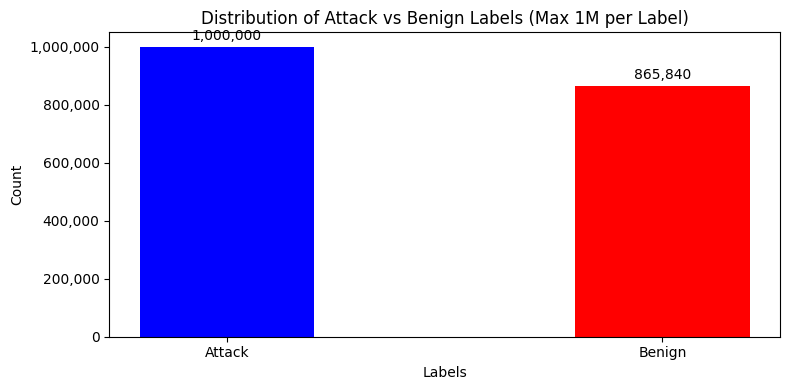

📦 Dữ liệu đã được lưu tại processed_data/data_2labels_1M.csv


In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import cudf  # Dùng cuDF để xử lý dữ liệu nhanh hơn trên GPU

# Định nghĩa thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Hàm gộp nhãn thành 2 nhãn: Attack và Benign
def change_label(df):
    attack_labels = {
        'DDoS-ICMP_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood',
        'DDoS-PSHACK_Flood', 'DDoS-SYN_Flood', 'DDoS-RSTFINFlood',
        'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Fragmentation',
        'DDoS-UDP_Fragmentation', 'DDoS-ACK_Fragmentation',
        'DDoS-HTTP_Flood', 'DDoS-SlowLoris', 'DoS-UDP_Flood',
        'DoS-TCP_Flood', 'DoS-SYN_Flood', 'DoS-HTTP_Flood',
        'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan',
        'Recon-PingSweep', 'VulnerabilityScan', 'MITM-ArpSpoofing',
        'DNS_Spoofing', 'DictionaryBruteForce', 'BrowserHijacking',
        'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection',
        'Backdoor_Malware', 'Mirai-greeth_flood', 'Mirai-udpplain',
        'Mirai-greip_flood'
    }

    # Thay thế tất cả nhãn attack thành "Attack"
    df["label"] = df["label"].replace(to_replace=list(attack_labels), value="Attack")
    
    # Thay thế "BenignTraffic" thành "Benign"
    df["label"] = df["label"].replace("BenignTraffic", "Benign")
    return df

# Đọc dữ liệu từ thư mục
data_dir = "/kaggle/input/cic-iot-2023/"
file_list = glob.glob(f"{data_dir}*.csv")[:134]  # Lấy tối đa 100 file

# Giới hạn tối đa 1,000,000 dòng cho mỗi nhãn (Attack và Benign)
MAX_ROWS_PER_LABEL = 1_000_000
label_counts = {"Attack": 0, "Benign": 0}  # Theo dõi số dòng của từng nhãn

def read_file(filename, index):
    try:
        # Đọc file CSV bằng cuDF
        df = cudf.read_csv(filename)
        
        # Kiểm tra cột 'label'
        if 'label' not in df.columns:
            print(f"❌ File {filename}: Không tìm thấy cột 'label'!")
            return None
        
        # Gộp nhãn thành Attack và Benign
        df = change_label(df)
        
        # Lọc dữ liệu dựa trên giới hạn 1M cho mỗi nhãn
        valid_rows = []
        unique_labels = df['label'].unique().to_pandas().tolist()
        for label in unique_labels:
            current_count = label_counts.get(label, 0)
            remaining_quota = MAX_ROWS_PER_LABEL - current_count
            
            if remaining_quota <= 0:
                print(f"⚠ Nhãn {label} đã đủ {MAX_ROWS_PER_LABEL:,} dòng, không đọc thêm!")
                continue
            
            # Lấy các dòng thuộc nhãn này
            label_df = df[df['label'] == label]
            rows_to_take = min(len(label_df), remaining_quota)
            
            if rows_to_take > 0:
                valid_rows.append(label_df[:rows_to_take])
                label_counts[label] = current_count + rows_to_take
                print(f"📌 Nhãn {label}: Thêm {rows_to_take:,} dòng, tổng cộng {label_counts[label]:,} dòng")
        
        # Gộp các dòng hợp lệ
        if valid_rows:
            df_filtered = cudf.concat(valid_rows, ignore_index=True)
            print(f"📌 File {index}: Giữ {df_filtered.shape[0]:,} dòng sau khi lọc giới hạn")
            return df_filtered
        else:
            print(f"⚠ File {index}: Không có dữ liệu nào được giữ lại!")
            return None
    except Exception as e:
        print(f"❌ Lỗi khi đọc file {filename}: {e}")
        return None

# Đọc tuần tự từng file
dfs = []
for idx, fname in enumerate(file_list):
    df = read_file(fname, idx)
    if df is not None:
        dfs.append(df)

# Nối dữ liệu và vẽ biểu đồ
if dfs:
    df_full = cudf.concat(dfs, ignore_index=True)
    print(f"✅ Dữ liệu đã được nối! Kích thước: {df_full.shape}")
    print(f"📋 Nhãn duy nhất: {df_full['label'].unique().to_pandas().tolist()}")
    
    # Chuyển sang pandas để vẽ biểu đồ
    df_pandas = df_full.to_pandas()
    
    # Kiểm tra phân bố nhãn
    print("\n📋 Phân bố nhãn sau khi gộp:")
    print(df_pandas["label"].value_counts())
    
    # Vẽ biểu đồ phân bố nhãn
    fig, ax = plt.subplots(figsize=(8, 4))
    label_counts = df_pandas["label"].value_counts()

    bars = ax.bar(label_counts.index, label_counts.values, width=0.4, color=['blue', 'red'])
    plt.xticks(rotation=0, ha='center', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    ax.set_xlabel('Labels')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Attack vs Benign Labels (Max 1M per Label)')

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution_2labels_1M.png')  # Lưu biểu đồ
    plt.show()
    
    # Lưu dữ liệu để sử dụng ở các bước sau
    df_pandas.to_csv(f"{output_dir}/data_2labels_1M.csv", index=False)
    print(f"📦 Dữ liệu đã được lưu tại {output_dir}/data_2labels_1M.csv")
else:
    print("⚠ Không có file nào được đọc thành công hoặc tất cả dữ liệu rỗng!")

# **ÁNH XẠ NHÃN**

📋 Nhãn duy nhất trong dữ liệu: ['Attack', 'Benign']
📊 Ánh xạ nhãn (2 nhãn): {'Attack': 0, 'Benign': 1}

📊 Phân bố nhãn trong tập huấn luyện:
Benign    650000
Attack    562796
Name: count, dtype: int64

📊 Phân bố nhãn trong tập validation:
Benign    150000
Attack    129876
Name: count, dtype: int64

📊 Phân bố nhãn trong tập kiểm tra:
Benign    200000
Attack    173168
Name: count, dtype: int64
🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:
            IAT  Weight  Number  rst_count  urg_count  Variance   Tot size  \
min -110.559660 -140.55    -8.5  -0.001763  -0.014347 -0.211111  -0.064690   
max  112.408913  103.05     5.5  16.174396  61.857963  0.900000  36.433962   

           Max  Magnitue        AVG  
min  -0.058294 -0.139120  -0.069065  
max  32.524304  8.450362  34.839941  
🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:
            IAT  Weight  Number  rst_count  urg_count  Variance   Tot size  \
min -110.559660 -140.55    -8.5  -0.001763  -0.014347 -0.211111  -0.064690  

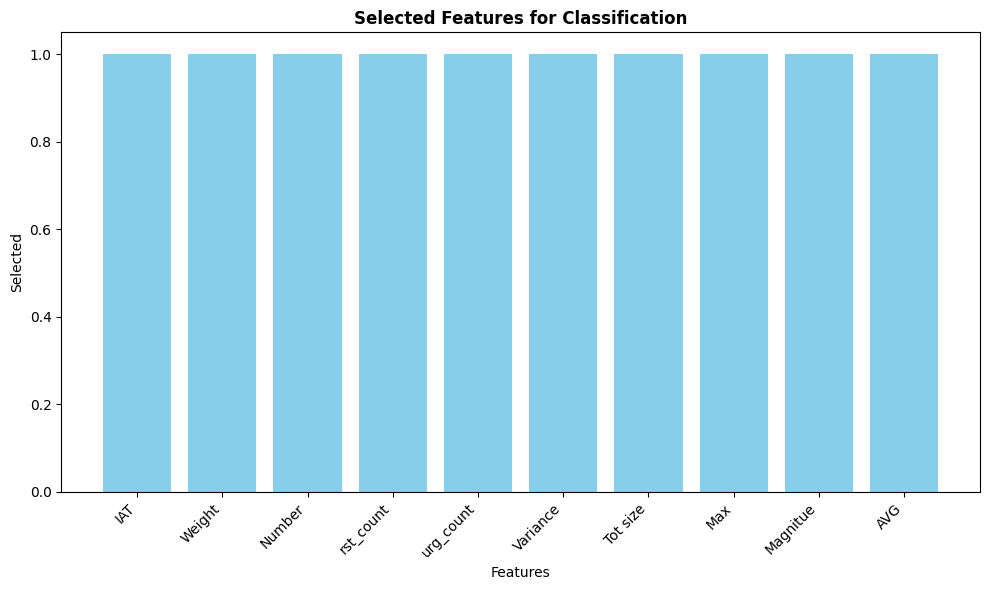

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer
import pickle
import os
import matplotlib.pyplot as plt

# Đường dẫn lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

# Giả định df_full là DataFrame từ cell đọc dữ liệu trước đó (cuDF)
# Chuyển từ cuDF sang Pandas
df_original = df_full.to_pandas()

# Kiểm tra dữ liệu đầu vào
if df_original.empty or 'label' not in df_original.columns:
    raise ValueError("❌ Dữ liệu đầu vào rỗng hoặc thiếu cột 'label'!")

# Xử lý giá trị thiếu cho cột số
numeric_columns = df_original.select_dtypes(include=[np.number]).columns
df_original[numeric_columns] = df_original[numeric_columns].fillna(df_original[numeric_columns].mean())

# Tách đặc trưng và nhãn
X = df_original.drop(columns=['label']).select_dtypes(include=[np.number])
y = df_original['label']

# Kiểm tra nhãn duy nhất
print("📋 Nhãn duy nhất trong dữ liệu:", y.unique().tolist())

# Sử dụng danh sách đặc trưng cố định
top_features = ['IAT', 'Weight', 'Number', 'rst_count', 'urg_count', 'Variance', 'Tot size', 'Max', 'Magnitue', 'AVG']

# Kiểm tra xem các đặc trưng có tồn tại trong dữ liệu không
missing_features = [f for f in top_features if f not in X.columns]
if missing_features:
    raise ValueError(f"❌ Các đặc trưng sau không tồn tại trong dữ liệu: {missing_features}")

# Lấy chỉ số của các đặc trưng đã chọn
feature_indices = [list(X.columns).index(f) for f in top_features]

# Áp dụng các đặc trưng đã chọn trước khi chia dữ liệu
X = X[top_features]

# Chia dữ liệu thành tập train, val, test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.1875, stratify=Y_temp, random_state=42)

# Mã hóa nhãn (2 nhãn: Benign = 0, Attack = 1)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("📊 Ánh xạ nhãn (2 nhãn):", label_mapping)

# Kiểm tra phân bố nhãn
print("\n📊 Phân bố nhãn trong tập huấn luyện:")
print(pd.Series(Y_train_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))
print("\n📊 Phân bố nhãn trong tập validation:")
print(pd.Series(Y_val_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))
print("\n📊 Phân bố nhãn trong tập kiểm tra:")
print(pd.Series(Y_test_encoded).value_counts().rename({0: 'Benign', 1: 'Attack'}))

# Xử lý NaN và outlier bằng KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Chuẩn hóa dữ liệu bằng RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Kiểm tra giá trị sau khi chọn đặc trưng
print("🔍 Giá trị tối đa và tối thiểu trong X_train_scaled:")
print(pd.DataFrame(X_train_scaled, columns=top_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_val_scaled:")
print(pd.DataFrame(X_val_scaled, columns=top_features).describe().loc[['min', 'max']])
print("🔍 Giá trị tối đa và tối thiểu trong X_test_scaled:")
print(pd.DataFrame(X_test_scaled, columns=top_features).describe().loc[['min', 'max']])

# Lưu dữ liệu đã xử lý
np.save(f"{output_dir}/X_train_scaled_2labels.npy", X_train_scaled)
np.save(f"{output_dir}/Y_train_encoded_2labels.npy", Y_train_encoded)
np.save(f"{output_dir}/X_val_scaled_2labels.npy", X_val_scaled)
np.save(f"{output_dir}/Y_val_encoded_2labels.npy", Y_val_encoded)
np.save(f"{output_dir}/X_test_scaled_2labels.npy", X_test_scaled)
np.save(f"{output_dir}/Y_test_encoded_2labels.npy", Y_test_encoded)

# Lưu các đối tượng xử lý
with open(f"{output_dir}/label_encoder_2labels.pkl", 'wb') as f:
    pickle.dump(label_encoder, f)
with open(f"{output_dir}/scaler_2labels.pkl", 'wb') as f:
    pickle.dump(scaler, f)
with open(f"{output_dir}/imputer_2labels.pkl", 'wb') as f:
    pickle.dump(imputer, f)
with open(f"{output_dir}/selected_features_2labels.pkl", 'wb') as f:
    pickle.dump(top_features, f)

# In thông tin chi tiết
print(f"✅ Dữ liệu đã xử lý và lưu trong '{output_dir}'!")
print(f"📌 Số đặc trưng được chọn: {len(top_features)}")
print(f"📋 Các đặc trưng được chọn: {top_features}")

# Vẽ biểu đồ danh sách đặc trưng được chọn
plt.figure(figsize=(10, 6))
plt.bar(top_features, [1] * len(top_features), color='skyblue')
plt.title('Selected Features for Classification', fontsize=12, fontweight='bold')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Selected', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{output_dir}/selected_features_2labels.png")
plt.show()

# **LẤY SOFT LABLE**

In [6]:
import numpy as np
import xgboost as xgb
import joblib
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Tải dữ liệu đã xử lý (2 nhãn, 10 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")

# Kiểm tra kích thước dữ liệu
print(f"📏 Kích thước X_train_scaled: {X_train_scaled.shape}")
print(f"📏 Kích thước X_val_scaled: {X_val_scaled.shape}")
print(f"📏 Kích thước X_test_scaled: {X_test_scaled.shape}")
print(f"📋 Nhãn duy nhất trong Y_train_encoded: {np.unique(Y_train_encoded)}")

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_val_scaled = scaler.transform(X_val_scaled)
X_test_scaled = scaler.transform(X_test_scaled)
joblib.dump(scaler, f"{results_dir}/xgboost_scaler_2labels.pkl")
tqdm.write(f"📦 Lưu StandardScaler tại {results_dir}/xgboost_scaler_2labels.pkl")

# Thiết lập tham số XGBoost cho phân loại nhị phân
xgb_params = {
    'objective': 'binary:logistic',  # Phân loại nhị phân
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,  # Giảm số cây để tăng tốc độ
    'eval_metric': 'logloss',
    'random_state': 42
}

# Huấn luyện mô hình XGBoost
tqdm.write("🚀 Bắt đầu huấn luyện XGBoost...")
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train_scaled, Y_train_encoded)

# Lấy soft labels (xác suất)
soft_labels_train = xgb_model.predict_proba(X_train_scaled)
soft_labels_val = xgb_model.predict_proba(X_val_scaled)
soft_labels_test = xgb_model.predict_proba(X_test_scaled)

# Kiểm tra kích thước soft labels
print(f"📏 Kích thước soft_labels_train: {soft_labels_train.shape}")
print(f"📏 Kích thước soft_labels_val: {soft_labels_val.shape}")
print(f"📏 Kích thước soft_labels_test: {soft_labels_test.shape}")

# Lưu mô hình XGBoost
xgb_model.save_model(f"{results_dir}/xgboost_model_2labels.json")
tqdm.write(f"📦 Lưu mô hình XGBoost tại {results_dir}/xgboost_model_2labels.json")

# Lưu soft labels
np.save(f"{results_dir}/soft_labels_train_2labels.npy", soft_labels_train)
np.save(f"{results_dir}/soft_labels_val_2labels.npy", soft_labels_val)
np.save(f"{results_dir}/soft_labels_test_2labels.npy", soft_labels_test)
tqdm.write(f"📦 Lưu soft labels tại {results_dir}/ (soft_labels_train_2labels.npy, soft_labels_val_2labels.npy, soft_labels_test_2labels.npy)")

tqdm.write("✅ Hoàn thành lấy và lưu soft labels từ XGBoost!")

📏 Kích thước X_train_scaled: (1212796, 10)
📏 Kích thước X_val_scaled: (279876, 10)
📏 Kích thước X_test_scaled: (373168, 10)
📋 Nhãn duy nhất trong Y_train_encoded: [0 1]
📦 Lưu StandardScaler tại results/xgboost_scaler_2labels.pkl
🚀 Bắt đầu huấn luyện XGBoost...
📏 Kích thước soft_labels_train: (1212796, 2)
📏 Kích thước soft_labels_val: (279876, 2)
📏 Kích thước soft_labels_test: (373168, 2)
📦 Lưu mô hình XGBoost tại results/xgboost_model_2labels.json
📦 Lưu soft labels tại results/ (soft_labels_train_2labels.npy, soft_labels_val_2labels.npy, soft_labels_test_2labels.npy)
✅ Hoàn thành lấy và lưu soft labels từ XGBoost!


# **MÔ HÌNH DCN-V2  33.51 giây**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# DCN-V2 Cross Layer
class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, 1))
        self.bias = nn.Parameter(torch.zeros(input_dim))
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        x0 = x
        xw = torch.matmul(x0, self.weight)
        x = x0 * xw + x0 + self.bias
        return x

# DCN-V2 Model
class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc_embed = nn.Linear(input_dim + deep_layer_dim, embed_dim)  # Dùng cho Stage 1
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)     # Dùng cho Stage 2
        nn.init.xavier_normal_(self.combine_fc_embed.weight)
        nn.init.xavier_normal_(self.combine_fc.weight)
        nn.init.zeros_(self.combine_fc_embed.bias)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        if stage == 'feature_learning':
            output = self.combine_fc_embed(combined)
        else:  # stage == 'classification'
            output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        sparsity_loss = torch.mean(-importance * torch.log(importance + 1e-8))
        masks = [importance]
        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn, 10 đặc trưng)
X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")

# Tải soft labels từ XGBoost (2 nhãn)
soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
tqdm.write(f"📦 Đã tải soft labels từ {results_dir}/ (soft_labels_train_2labels.npy, soft_labels_val_2labels.npy, soft_labels_test_2labels.npy)")

# Không nối soft labels vào đầu vào (loại bỏ feature augmentation)
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled

# Kiểm tra kích thước dữ liệu
print(f"📏 Kích thước X_train_aug: {X_train_aug.shape}")
print(f"📏 Kích thước X_val_aug: {X_val_aug.shape}")
print(f"📏 Kích thước X_test_aug: {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 10 đặc trưng
model = DCNV2(input_dim=input_dim, num_classes=2, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()  # Dùng cho phân loại nhị phân
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.05  # Giảm từ 0.5 xuống 0.1 để giảm ảnh hưởng của soft label
temperature = 5.0  # Tăng từ 2.0 lên 5.0 để làm mềm phân phối xác suất

# Stage 1: Feature Learning
print("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL + Sparsity Loss
print("Stage 2: Classification with BCE + KL + Sparsity Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            logits, sparsity_loss, masks = model(X_batch, stage='classification')
            # Chuyển Y_batch thành one-hot cho BCEWithLogitsLoss
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(logits, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(logits / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                logits, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(logits, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(logits / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss + 1e-8 * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # Chỉ 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/dcnv2_2labels_no_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/dcnv2_2labels_no_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/dcnv2_2labels_no_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_2labels_no_soft_label_input.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/dcnv2_2labels_no_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            logits, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(logits, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(torch.cat([X_batch, logits], dim=1).cpu().numpy())
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

pred_counts = np.bincount(test_preds, minlength=2)  # Chỉ 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_2labels_no_soft_label_input.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_2labels_no_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

📦 Đã tải soft labels từ results/ (soft_labels_train_2labels.npy, soft_labels_val_2labels.npy, soft_labels_test_2labels.npy)
📏 Kích thước X_train_aug: (1212796, 10)
📏 Kích thước X_val_aug: (279876, 10)
📏 Kích thước X_test_aug: (373168, 10)
📡 Thiết bị: cuda
Stage 1: Feature Learning with Contrastive Loss


✅ Epoch 1/5, Train Loss: 119058418.8604, Time: 33.69s


✅ Epoch 2/5, Train Loss: 7608.2084, Time: 34.24s


✅ Epoch 3/5, Train Loss: 10.8909, Time: 34.07s


✅ Epoch 4/5, Train Loss: 4.4163, Time: 34.10s


✅ Epoch 5/5, Train Loss: 2.5756, Time: 34.28s
Stage 2: Classification with BCE + KL + Sparsity Loss


✅ Epoch 1/100: Train Loss: 0.0598, Val Loss: 0.0429, Train Acc: 98.74%, Val Acc: 98.98%, F1: 0.9898, Precision: 0.9900, Recall: 0.9898, Time: 34.13s
Phân bố dự đoán (Validation): [147171 132705]
Confusion Matrix:
[[147157   2843]
 [    14 129862]]
📦 Lưu mô hình tốt nhất tại epoch 1


✅ Epoch 2/100: Train Loss: 0.0437, Val Loss: 0.0410, Train Acc: 98.99%, Val Acc: 99.00%, F1: 0.9901, Precision: 0.9903, Recall: 0.9900, Time: 33.22s
Phân bố dự đoán (Validation): [147240 132636]
Confusion Matrix:
[[147227   2773]
 [    13 129863]]
📦 Lưu mô hình tốt nhất tại epoch 2


✅ Epoch 3/100: Train Loss: 0.0423, Val Loss: 0.0404, Train Acc: 99.00%, Val Acc: 98.99%, F1: 0.9899, Precision: 0.9902, Recall: 0.9899, Time: 33.97s
Phân bố dự đoán (Validation): [147191 132685]
Confusion Matrix:
[[147188   2812]
 [     3 129873]]


✅ Epoch 4/100: Train Loss: 0.0414, Val Loss: 0.0397, Train Acc: 99.00%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 33.81s
Phân bố dự đoán (Validation): [147221 132655]
Confusion Matrix:
[[147220   2780]
 [     1 129875]]
📦 Lưu mô hình tốt nhất tại epoch 4


✅ Epoch 5/100: Train Loss: 0.0410, Val Loss: 0.0393, Train Acc: 99.01%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 33.64s
Phân bố dự đoán (Validation): [147260 132616]
Confusion Matrix:
[[147258   2742]
 [     2 129874]]
📦 Lưu mô hình tốt nhất tại epoch 5


✅ Epoch 6/100: Train Loss: 0.0406, Val Loss: 0.0388, Train Acc: 99.01%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 33.64s
Phân bố dự đoán (Validation): [147241 132635]
Confusion Matrix:
[[147241   2759]
 [     0 129876]]


✅ Epoch 7/100: Train Loss: 0.0403, Val Loss: 0.0385, Train Acc: 99.01%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 33.96s
Phân bố dự đoán (Validation): [147278 132598]
Confusion Matrix:
[[147275   2725]
 [     3 129873]]
📦 Lưu mô hình tốt nhất tại epoch 7


✅ Epoch 8/100: Train Loss: 0.0402, Val Loss: 0.0387, Train Acc: 99.02%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 33.95s
Phân bố dự đoán (Validation): [147236 132640]
Confusion Matrix:
[[147236   2764]
 [     0 129876]]


✅ Epoch 9/100: Train Loss: 0.0400, Val Loss: 0.0384, Train Acc: 99.01%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 33.21s
Phân bố dự đoán (Validation): [147266 132610]
Confusion Matrix:
[[147266   2734]
 [     0 129876]]


✅ Epoch 10/100: Train Loss: 0.0399, Val Loss: 0.0386, Train Acc: 99.02%, Val Acc: 99.02%, F1: 0.9903, Precision: 0.9904, Recall: 0.9902, Time: 33.66s
Phân bố dự đoán (Validation): [147271 132605]
Confusion Matrix:
[[147271   2729]
 [     0 129876]]


✅ Epoch 11/100: Train Loss: 0.0399, Val Loss: 0.0384, Train Acc: 99.01%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 33.10s
Phân bố dự đoán (Validation): [147284 132592]
Confusion Matrix:
[[147280   2720]
 [     4 129872]]
📦 Lưu mô hình tốt nhất tại epoch 11


✅ Epoch 12/100: Train Loss: 0.0394, Val Loss: 0.0380, Train Acc: 99.02%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 33.71s
Phân bố dự đoán (Validation): [147321 132555]
Confusion Matrix:
[[147315   2685]
 [     6 129870]]
📦 Lưu mô hình tốt nhất tại epoch 12


✅ Epoch 13/100: Train Loss: 0.0392, Val Loss: 0.0376, Train Acc: 99.03%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 33.41s
Phân bố dự đoán (Validation): [147347 132529]
Confusion Matrix:
[[147341   2659]
 [     6 129870]]
📦 Lưu mô hình tốt nhất tại epoch 13


✅ Epoch 14/100: Train Loss: 0.0388, Val Loss: 0.0374, Train Acc: 99.03%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 33.82s
Phân bố dự đoán (Validation): [147415 132461]
Confusion Matrix:
[[147379   2621]
 [    36 129840]]
📦 Lưu mô hình tốt nhất tại epoch 14


✅ Epoch 15/100: Train Loss: 0.0387, Val Loss: 0.0371, Train Acc: 99.03%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 33.38s
Phân bố dự đoán (Validation): [147480 132396]
Confusion Matrix:
[[147454   2546]
 [    26 129850]]
📦 Lưu mô hình tốt nhất tại epoch 15


✅ Epoch 16/100: Train Loss: 0.0385, Val Loss: 0.0371, Train Acc: 99.04%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 33.85s
Phân bố dự đoán (Validation): [147397 132479]
Confusion Matrix:
[[147381   2619]
 [    16 129860]]


Training Batch (Epoch 17/100):  22%|██▏       | 529/2368 [00:06<00:20, 90.20batch/s, loss=0.0514]

**VẼ CÁC SƠ ĐỒ DCN-V2**

✅ Đã tải tất cả dữ liệu cần thiết cho DCN-V2


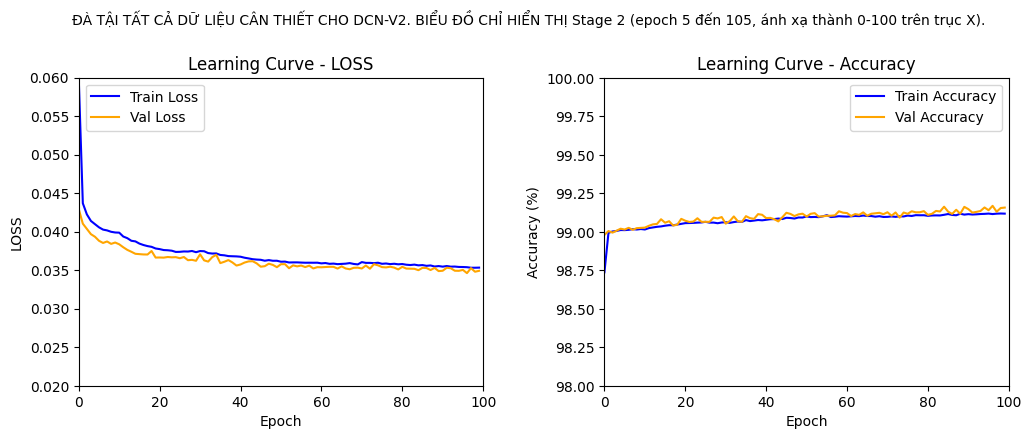

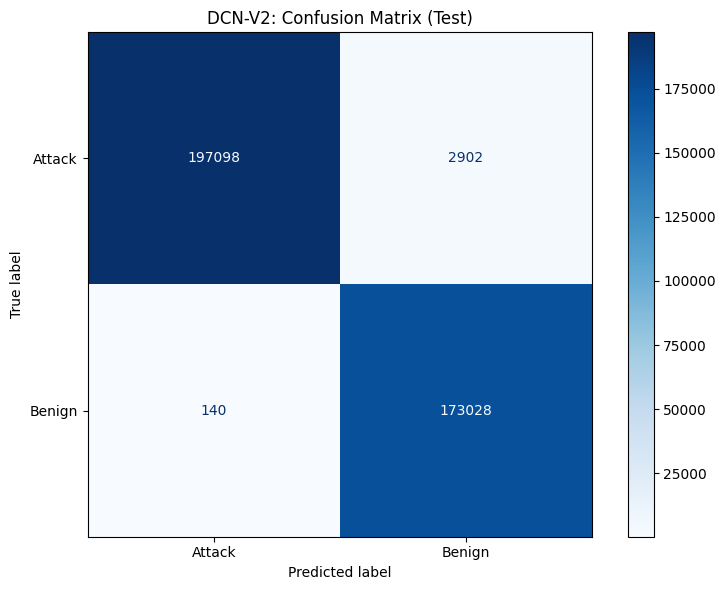

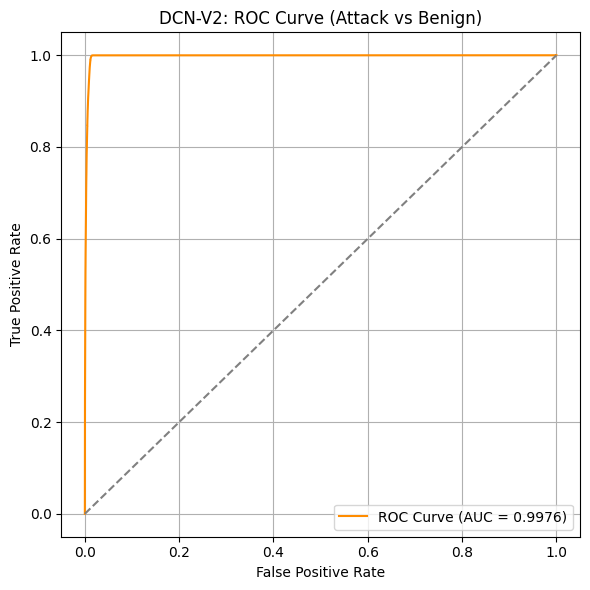

📈 ROC-AUC Score (Attack vs Benign): 0.9976
Shape of test_features: (373168, 12)


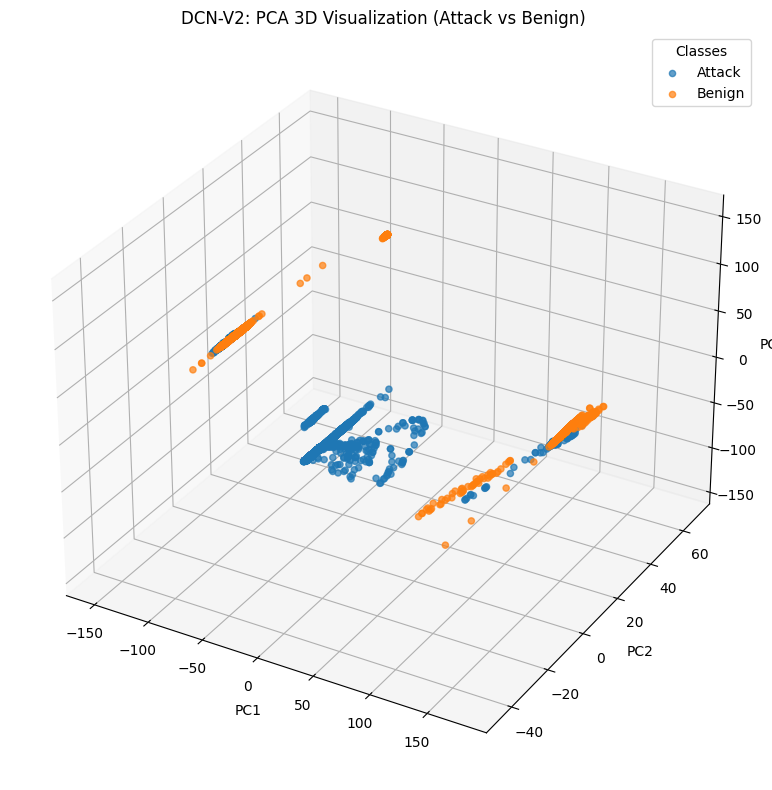

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 33.51 giây


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_no_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho DCN-V2")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột, kích thước 12x4

# Biểu đồ Loss (bên trái) - Trục Y từ 0.02 đến 0.06
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("LOSS")
ax1.set_title("Learning Curve - LOSS")
ax1.legend(loc="upper left")
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax1.set_ylim(0.02, 0.06)  # Trục Y từ 0.02 đến 0.06

# Biểu đồ Accuracy (bên phải) - Thu hẹp trục Y để làm rõ dao động
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Learning Curve - Accuracy")
ax2.legend(loc="upper right")
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax2.set_ylim(98, 100)  # Thu hẹp trục Y từ 98% đến 100% để làm rõ dao động

# Thêm ghi chú phía trên biểu đồ (cập nhật để phản ánh việc chỉ vẽ Stage 2)
plt.suptitle("ĐÀ TẬI TẤT CẢ DỮ LIỆU CÂN THIẾT CHO DCN-V2. BIỂU ĐỒ CHỈ HIỂN THỊ Stage 2 (epoch 5 đến 105, ánh xạ thành 0-100 trên trục X).", 
             fontsize=10, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_dcnv2_2labels_no_soft_label_input.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("DCN-V2: Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_dcnv2_2labels_no_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DCN-V2: ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_dcnv2_2labels_no_soft_label_input.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("DCN-V2: PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_dcnv2_2labels_no_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

**TEST FILE THỰC TẾ**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import joblib
import xgboost as xgb
import pickle
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Các lớp mô hình từ code huấn luyện
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

class CrossLayer(nn.Module):
    def __init__(self, input_dim):
        super(CrossLayer, self).__init__()
        self.weight = nn.Parameter(torch.randn(input_dim, 1))
        self.bias = nn.Parameter(torch.zeros(input_dim))
        nn.init.xavier_normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        x0 = x
        xw = torch.matmul(x0, self.weight)
        x = x0 * xw + x0 + self.bias
        return x

class DCNV2(nn.Module):
    def __init__(self, input_dim, num_classes, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64):
        super(DCNV2, self).__init__()
        self.input_dim = input_dim
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.cross_layers = nn.ModuleList([CrossLayer(input_dim) for _ in range(n_cross_layers)])
        deep_layers = []
        prev_dim = input_dim
        for _ in range(n_deep_layers):
            deep_layers.extend([
                nn.Linear(prev_dim, deep_layer_dim),
                nn.BatchNorm1d(deep_layer_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = deep_layer_dim
        self.deep = nn.Sequential(*deep_layers)
        self.combine_fc_embed = nn.Linear(input_dim + deep_layer_dim, embed_dim)
        self.combine_fc = nn.Linear(input_dim + deep_layer_dim, num_classes)
        nn.init.xavier_normal_(self.combine_fc_embed.weight)
        nn.init.xavier_normal_(self.combine_fc.weight)
        nn.init.zeros_(self.combine_fc_embed.bias)
        nn.init.zeros_(self.combine_fc.bias)
        self.importance_layer = nn.Linear(input_dim, input_dim)
        nn.init.xavier_normal_(self.importance_layer.weight)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        x_cross = x
        for layer in self.cross_layers:
            x_cross = layer(x_cross)
        x_deep = self.deep(x)
        combined = torch.cat([x_cross, x_deep], dim=1)
        if stage == 'feature_learning':
            output = self.combine_fc_embed(combined)
        else:
            output = self.combine_fc(combined)
        importance = torch.sigmoid(self.importance_layer(x))
        sparsity_loss = torch.mean(-importance * torch.log(importance + 1e-8))
        masks = [importance]
        return output, sparsity_loss, masks

# Hàm ánh xạ nhãn thành 2 nhãn: Attack và Benign
def change_label(df):
    attack_labels = {
        'DDoS-ICMP_Flood', 'DDoS-UDP_Flood', 'DDoS-TCP_Flood',
        'DDoS-PSHACK_Flood', 'DDoS-SYN_Flood', 'DDoS-RSTFINFlood',
        'DDoS-SynonymousIP_Flood', 'DDoS-ICMP_Fragmentation',
        'DDoS-UDP_Fragmentation', 'DDoS-ACK_Fragmentation',
        'DDoS-HTTP_Flood', 'DDoS-SlowLoris', 'DoS-UDP_Flood',
        'DoS-TCP_Flood', 'DoS-SYN_Flood', 'DoS-HTTP_Flood',
        'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan',
        'Recon-PingSweep', 'VulnerabilityScan', 'MITM-ArpSpoofing',
        'DNS_Spoofing', 'DictionaryBruteForce', 'BrowserHijacking',
        'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection',
        'Backdoor_Malware', 'Mirai-greeth_flood', 'Mirai-udpplain',
        'Mirai-greip_flood'
    }
    df["label"] = df["label"].replace(to_replace=list(attack_labels), value="Attack")
    df["label"] = df["label"].replace("BenignTraffic", "Benign")
    return df

# Hàm xử lý dữ liệu thực tế
def preprocess_real_data(file_path, selected_features, imputer, scaler, xgb_model, xgb_scaler, label_encoder):
    try:
        # Đọc dữ liệu thực tế
        df_real = pd.read_csv(file_path)
        tqdm.write(f"📂 Đã đọc dữ liệu thực tế từ {file_path}, shape: {df_real.shape}")

        # Ánh xạ nhãn
        if 'label' in df_real.columns:
            df_real = change_label(df_real)
            tqdm.write("✅ Đã ánh xạ nhãn thành Attack và Benign")

        # Xử lý giá trị thiếu cho cột số
        numeric_columns = df_real.select_dtypes(include=[np.number]).columns
        df_real[numeric_columns] = df_real[numeric_columns].fillna(df_real[numeric_columns].mean())

        # Kiểm tra xem các đặc trưng đã chọn có trong dữ liệu không
        missing_features = [f for f in selected_features if f not in df_real.columns]
        if missing_features:
            raise ValueError(f"Các đặc trưng sau không có trong dữ liệu: {missing_features}")

        # Chỉ lấy các đặc trưng đã chọn
        X_real = df_real[selected_features]
        tqdm.write(f"📋 Sử dụng {len(selected_features)} đặc trưng: {selected_features}")

        # Xử lý NaN bằng KNNImputer
        X_real_imputed = imputer.transform(X_real)
        tqdm.write("✅ Đã xử lý giá trị thiếu bằng KNNImputer")

        # Chuẩn hóa dữ liệu bằng RobustScaler
        X_real_scaled = scaler.transform(X_real_imputed)
        tqdm.write("✅ Đã chuẩn hóa dữ liệu bằng RobustScaler")

        # Chuẩn hóa cho XGBoost
        X_real_xgb_scaled = xgb_scaler.transform(X_real_scaled)
        tqdm.write("✅ Đã chuẩn hóa dữ liệu cho XGBoost bằng StandardScaler")

        # Lấy soft labels từ XGBoost
        soft_labels_real = xgb_model.predict_proba(X_real_xgb_scaled)
        tqdm.write("✅ Đã tạo soft labels từ XGBoost")

        # Nối soft labels vào dữ liệu
        X_real_aug = np.concatenate([X_real_scaled, soft_labels_real], axis=1)
        tqdm.write(f"📊 Dữ liệu sau khi nối soft labels, shape: {X_real_aug.shape}")

        # Chuyển thành tensor
        X_real_tensor = torch.tensor(X_real_aug, dtype=torch.float32)

        # Nếu có nhãn trong dữ liệu thực tế, mã hóa nhãn
        Y_real_tensor = None
        if 'label' in df_real.columns:
            unique_labels = df_real['label'].unique()
            unknown_labels = [label for label in unique_labels if label not in label_encoder.classes_]
            if unknown_labels:
                raise ValueError(f"Nhãn chưa được ánh xạ đúng hoặc không có trong LabelEncoder: {unknown_labels}")
            Y_real_encoded = label_encoder.transform(df_real['label'])
            Y_real_tensor = torch.tensor(Y_real_encoded, dtype=torch.long)
            tqdm.write("✅ Đã mã hóa nhãn thực tế")

        return X_real_tensor, Y_real_tensor, soft_labels_real

    except Exception as e:
        tqdm.write(f"❌ Lỗi trong preprocess_real_data: {str(e)}")
        raise

# Hàm dự đoán
def predict(model, X_tensor, device, batch_size=512):
    try:
        model.eval()
        predictions = []
        probabilities = []

        # Tạo DataLoader
        dataset = TensorDataset(X_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            for X_batch in tqdm(loader, desc="Predicting", unit="batch"):
                X_batch = X_batch[0].to(device)
                outputs, _, _ = model(X_batch, stage='classification')
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                predictions.extend(preds.cpu().numpy())
                probabilities.extend(probs.cpu().numpy())

        return np.array(predictions), np.array(probabilities)

    except Exception as e:
        tqdm.write(f"❌ Lỗi trong predict: {str(e)}")
        raise

# Main
def main():
    # Đường dẫn đến file dữ liệu thực tế
    real_data_path = "/kaggle/input/cic-iot-2023/part-00024-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
    output_dir = "processed_data"
    results_dir = "results"
    model_path = f"{results_dir}/dcnv2_2labels.pth"
    output_csv_path = f"{results_dir}/predictions_real_data_2labels.csv"

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tqdm.write(f"📡 Thiết bị: {device}")

    try:
        # Tải các đối tượng xử lý
        with open(f"{output_dir}/imputer_2labels.pkl", 'rb') as f:
            imputer = pickle.load(f)
        with open(f"{output_dir}/scaler_2labels.pkl", 'rb') as f:
            scaler = pickle.load(f)
        with open(f"{output_dir}/label_encoder_2labels.pkl", 'rb') as f:
            label_encoder = pickle.load(f)
        with open(f"{output_dir}/selected_features_2labels.pkl", 'rb') as f:
            selected_features = pickle.load(f)
        xgb_scaler = joblib.load(f"{results_dir}/xgboost_scaler_2labels.pkl")

        # Tải mô hình XGBoost
        xgb_model = xgb.XGBClassifier()
        xgb_model.load_model(f"{results_dir}/xgboost_model_2labels.json")
        tqdm.write(f"✅ Đã tải mô hình XGBoost từ {results_dir}/xgboost_model_2labels.json")

        # Tải và xử lý dữ liệu thực tế
        X_real_tensor, Y_real_tensor, soft_labels_real = preprocess_real_data(
            real_data_path, selected_features, imputer, scaler, xgb_model, xgb_scaler, label_encoder
        )

        # Khởi tạo mô hình
        model = DCNV2(input_dim=12, num_classes=2, n_cross_layers=3, n_deep_layers=3, deep_layer_dim=128, embed_dim=64).to(device)
        model.load_state_dict(torch.load(model_path, weights_only=True))
        tqdm.write(f"✅ Đã tải mô hình từ {model_path}")

        # Dự đoán
        predictions, probabilities = predict(model, X_real_tensor, device)
        tqdm.write(f"✅ Hoàn thành dự đoán, shape dự đoán: {predictions.shape}, shape xác suất: {probabilities.shape}")

        # Chuyển ngược dự đoán thành nhãn gốc
        predicted_labels = label_encoder.inverse_transform(predictions)

        # Lưu kết quả
        df_real = pd.read_csv(real_data_path)
        df_real = change_label(df_real)  # Ánh xạ nhãn cho True_Label
        result_df = pd.DataFrame({
            'Index': df_real.index,
            'Predicted_Label': predicted_labels,
            'True_Label': df_real['label'] if 'label' in df_real.columns else None
        })
        for i, class_name in enumerate(label_encoder.classes_):
            result_df[f'Prob_{class_name}'] = probabilities[:, i]

        result_df.to_csv(output_csv_path, index=False)
        tqdm.write(f"📦 Đã lưu kết quả dự đoán tại {output_csv_path}")

        # Nếu có nhãn thực tế, đánh giá hiệu suất
        if Y_real_tensor is not None:
            true_labels = Y_real_tensor.numpy()
            acc = accuracy_score(true_labels, predictions) * 100
            f1 = f1_score(true_labels, predictions, average='weighted')
            precision = precision_score(true_labels, predictions, average='weighted', zero_division=0)
            recall = recall_score(true_labels, predictions, average='weighted')
            cm = confusion_matrix(true_labels, predictions)

            tqdm.write(f"\n📊 Kết quả trên dữ liệu thực tế:")
            tqdm.write(f"Accuracy: {acc:.2f}%")
            tqdm.write(f"F1 Score: {f1:.4f}")
            tqdm.write(f"Precision: {precision:.4f}")
            tqdm.write(f"Recall: {recall:.4f}")
            tqdm.write(f"Confusion Matrix:\n{cm}")

    except Exception as e:
        tqdm.write(f"❌ Lỗi trong main: {str(e)}")
        raise

if __name__ == "__main__":
    main()

# **MÔ HÌNH TABNET 47.95 giây**

Consider increasing the number of samples or features.
⏱️ Thời gian huấn luyện trung bình mỗi epoch: 44.71 giây


Train Loss trung bình: 0.0364
Val Loss trung bình: 0.0359
Train Accuracy trung bình: 99.10%
Val Accuracy trung bình: 99.11%


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
results_dir = "results"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Entmax
def entmax15(x, dim=-1):
    x = F.softmax(x * 1.5, dim=dim)
    return x

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# TabNet thuần túy
class TabNet(nn.Module):
    def __init__(self, input_dim, num_classes, n_d=64, n_a=64, n_steps=5, gamma=1.3, lambda_sparse=1e-8):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lambda_sparse = lambda_sparse

        # BatchNorm đầu vào
        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)

        # Lớp FC ban đầu
        self.initial_fc = nn.Linear(input_dim, n_d + n_a)
        nn.init.xavier_normal_(self.initial_fc.weight)
        nn.init.zeros_(self.initial_fc.bias)

        # Các lớp chú ý (attention) và quyết định (decision) cho từng bước
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_a, input_dim),
                nn.BatchNorm1d(input_dim),
                nn.ReLU()
            ) for _ in range(n_steps)
        ])
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Dropout(0.2)
            ) for _ in range(n_steps)
        ])

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(n_d * n_steps, n_d)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(n_d * n_steps, num_classes)  # Dùng trong Stage 2
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        prior = torch.ones_like(x)
        outputs = []
        sparsity_loss = 0
        masks = []

        for step in range(self.n_steps):
            # Tạo đặc trưng chú ý và quyết định
            att = self.initial_fc(x)
            att_d, att_a = att[:, :self.n_d], att[:, self.n_d:]
            mask = self.attention_layers[step](att_a)
            mask = entmax15(mask, dim=1)
            
            # Tính sparsity loss
            entropy = -torch.sum(mask * torch.log(mask + 1e-8), dim=1)
            sparsity_loss += torch.mean(entropy) / self.n_steps / self.input_dim
            masks.append(mask)

            # Cập nhật prior và áp dụng mask
            prior = prior * (self.gamma - mask)
            masked_x = x * mask

            # Tạo đầu ra quyết định
            out = self.decision_layers[step](masked_x)
            outputs.append(out)

        # Kết hợp đầu ra từ tất cả các bước
        combined = torch.cat(outputs, dim=1)  # [batch_size, n_d * n_steps]

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(combined)
        else:  # stage == 'classification'
            output = self.fc_output(combined)

        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn, 10 đặc trưng)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels từ XGBoost (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")

# Không nối soft labels vào đầu vào (giống DCN-V2)
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled
tqdm.write(f"✅ Sử dụng dữ liệu gốc (không nối soft labels), shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # Chỉ 10 đặc trưng
model = TabNet(input_dim=input_dim, num_classes=2, n_d=64, n_a=64, n_steps=5).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()  # Dùng cho phân loại nhị phân
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.05  # Giảm từ 0.5 xuống 0.05 để giảm ảnh hưởng của soft label
temperature = 5.0  # Tăng từ 2.0 lên 5.0 để làm mềm phân phối xác suất

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL + Sparsity Loss
tqdm.write("Stage 2: Classification with BCE + KL + Sparsity Loss (Reduced Soft Label Influence)")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            # Chuyển Y_batch thành one-hot cho BCEWithLogitsLoss
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss + model.lambda_sparse * sparsity_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss + model.lambda_sparse * sparsity_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # Chỉ 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/tabnet_2labels_no_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/tabnet_2labels_no_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/tabnet_2labels_no_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_2labels_no_soft_label_input.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/tabnet_2labels_no_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(outputs, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())  # Lưu logits
            if X_batch.size(0) == batch_size:
                test_masks.extend([mask.detach().cpu().numpy() for mask in masks])
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=2)  # Chỉ 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
if test_masks:
    shapes = [mask.shape for mask in test_masks]
    if len(set(shapes)) == 1:
        avg_mask = np.mean(np.stack(test_masks, axis=0), axis=(0, 1))
    else:
        tqdm.write(f"Warning: Inconsistent mask shapes: {shapes}")
        avg_mask = np.zeros((batch_size, input_dim))
else:
    avg_mask = np.zeros((batch_size, input_dim))

np.save(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_2labels_no_soft_label_input.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_2labels_no_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

✅ Đã tải dữ liệu scaled và nhãn
✅ Đã tải soft labels từ results
✅ Sử dụng dữ liệu gốc (không nối soft labels), shape: train (1212796, 10), val (279876, 10), test (373168, 10)
📡 Thiết bị: cuda
Stage 1: Feature Learning with Contrastive Loss


✅ Epoch 1/5, Train Loss: 2.6720, Time: 54.06s


✅ Epoch 2/5, Train Loss: 0.1303, Time: 52.97s


✅ Epoch 3/5, Train Loss: 0.1275, Time: 52.91s


✅ Epoch 4/5, Train Loss: 0.1269, Time: 53.07s


✅ Epoch 5/5, Train Loss: 0.1266, Time: 53.15s
Stage 2: Classification with BCE + KL + Sparsity Loss (Reduced Soft Label Influence)


✅ Epoch 1/100: Train Loss: 0.0633, Val Loss: 0.0407, Train Acc: 98.67%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 44.17s
Phân bố dự đoán (Validation): [147334 132542]
Confusion Matrix:
[[147287   2713]
 [    47 129829]]
📦 Lưu mô hình tốt nhất tại epoch 1


✅ Epoch 2/100: Train Loss: 0.0411, Val Loss: 0.0392, Train Acc: 99.01%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 44.37s
Phân bố dự đoán (Validation): [147415 132461]
Confusion Matrix:
[[147362   2638]
 [    53 129823]]
📦 Lưu mô hình tốt nhất tại epoch 2


✅ Epoch 3/100: Train Loss: 0.0398, Val Loss: 0.0384, Train Acc: 99.02%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 44.81s
Phân bố dự đoán (Validation): [147376 132500]
Confusion Matrix:
[[147326   2674]
 [    50 129826]]


✅ Epoch 4/100: Train Loss: 0.0390, Val Loss: 0.0377, Train Acc: 99.03%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9907, Recall: 0.9906, Time: 44.62s
Phân bố dự đoán (Validation): [147455 132421]
Confusion Matrix:
[[147406   2594]
 [    49 129827]]
📦 Lưu mô hình tốt nhất tại epoch 4


✅ Epoch 5/100: Train Loss: 0.0385, Val Loss: 0.0375, Train Acc: 99.04%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 44.45s
Phân bố dự đoán (Validation): [147483 132393]
Confusion Matrix:
[[147432   2568]
 [    51 129825]]
📦 Lưu mô hình tốt nhất tại epoch 5


✅ Epoch 6/100: Train Loss: 0.0382, Val Loss: 0.0375, Train Acc: 99.05%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 44.35s
Phân bố dự đoán (Validation): [147428 132448]
Confusion Matrix:
[[147389   2611]
 [    39 129837]]


✅ Epoch 7/100: Train Loss: 0.0379, Val Loss: 0.0373, Train Acc: 99.05%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9907, Recall: 0.9906, Time: 45.09s
Phân bố dự đoán (Validation): [147434 132442]
Confusion Matrix:
[[147397   2603]
 [    37 129839]]


✅ Epoch 8/100: Train Loss: 0.0379, Val Loss: 0.0370, Train Acc: 99.06%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 44.76s
Phân bố dự đoán (Validation): [147507 132369]
Confusion Matrix:
[[147464   2536]
 [    43 129833]]
📦 Lưu mô hình tốt nhất tại epoch 8


✅ Epoch 9/100: Train Loss: 0.0377, Val Loss: 0.0371, Train Acc: 99.06%, Val Acc: 99.06%, F1: 0.9907, Precision: 0.9908, Recall: 0.9906, Time: 44.67s
Phân bố dự đoán (Validation): [147458 132418]
Confusion Matrix:
[[147420   2580]
 [    38 129838]]


✅ Epoch 10/100: Train Loss: 0.0377, Val Loss: 0.0368, Train Acc: 99.06%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 44.87s
Phân bố dự đoán (Validation): [147532 132344]
Confusion Matrix:
[[147484   2516]
 [    48 129828]]
📦 Lưu mô hình tốt nhất tại epoch 10


✅ Epoch 11/100: Train Loss: 0.0379, Val Loss: 0.0371, Train Acc: 99.05%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 44.22s
Phân bố dự đoán (Validation): [147554 132322]
Confusion Matrix:
[[147501   2499]
 [    53 129823]]
📦 Lưu mô hình tốt nhất tại epoch 11


✅ Epoch 12/100: Train Loss: 0.0376, Val Loss: 0.0369, Train Acc: 99.06%, Val Acc: 99.06%, F1: 0.9906, Precision: 0.9908, Recall: 0.9906, Time: 44.77s
Phân bố dự đoán (Validation): [147472 132404]
Confusion Matrix:
[[147422   2578]
 [    50 129826]]


✅ Epoch 13/100: Train Loss: 0.0375, Val Loss: 0.0369, Train Acc: 99.06%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 44.62s
Phân bố dự đoán (Validation): [147603 132273]
Confusion Matrix:
[[147533   2467]
 [    70 129806]]
📦 Lưu mô hình tốt nhất tại epoch 13


✅ Epoch 14/100: Train Loss: 0.0372, Val Loss: 0.0370, Train Acc: 99.07%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9909, Recall: 0.9907, Time: 44.89s
Phân bố dự đoán (Validation): [147526 132350]
Confusion Matrix:
[[147466   2534]
 [    60 129816]]


✅ Epoch 15/100: Train Loss: 0.0372, Val Loss: 0.0365, Train Acc: 99.07%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 44.40s
Phân bố dự đoán (Validation): [147604 132272]
Confusion Matrix:
[[147516   2484]
 [    88 129788]]


✅ Epoch 16/100: Train Loss: 0.0370, Val Loss: 0.0366, Train Acc: 99.08%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 44.54s
Phân bố dự đoán (Validation): [147509 132367]
Confusion Matrix:
[[147465   2535]
 [    44 129832]]


✅ Epoch 17/100: Train Loss: 0.0370, Val Loss: 0.0362, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 44.71s
Phân bố dự đoán (Validation): [147662 132214]
Confusion Matrix:
[[147591   2409]
 [    71 129805]]
📦 Lưu mô hình tốt nhất tại epoch 17


✅ Epoch 18/100: Train Loss: 0.0368, Val Loss: 0.0361, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9914, Recall: 0.9912, Time: 44.52s
Phân bố dự đoán (Validation): [147719 132157]
Confusion Matrix:
[[147632   2368]
 [    87 129789]]
📦 Lưu mô hình tốt nhất tại epoch 18


✅ Epoch 19/100: Train Loss: 0.0367, Val Loss: 0.0363, Train Acc: 99.09%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 44.67s
Phân bố dự đoán (Validation): [147550 132326]
Confusion Matrix:
[[147499   2501]
 [    51 129825]]


✅ Epoch 20/100: Train Loss: 0.0366, Val Loss: 0.0363, Train Acc: 99.08%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 44.47s
Phân bố dự đoán (Validation): [147555 132321]
Confusion Matrix:
[[147504   2496]
 [    51 129825]]


✅ Epoch 21/100: Train Loss: 0.0365, Val Loss: 0.0364, Train Acc: 99.09%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 44.73s
Phân bố dự đoán (Validation): [147527 132349]
Confusion Matrix:
[[147486   2514]
 [    41 129835]]


✅ Epoch 22/100: Train Loss: 0.0365, Val Loss: 0.0364, Train Acc: 99.10%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 44.51s
Phân bố dự đoán (Validation): [147542 132334]
Confusion Matrix:
[[147492   2508]
 [    50 129826]]


✅ Epoch 23/100: Train Loss: 0.0365, Val Loss: 0.0360, Train Acc: 99.09%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 43.97s
Phân bố dự đoán (Validation): [147633 132243]
Confusion Matrix:
[[147556   2444]
 [    77 129799]]


✅ Epoch 24/100: Train Loss: 0.0363, Val Loss: 0.0360, Train Acc: 99.10%, Val Acc: 99.11%, F1: 0.9912, Precision: 0.9913, Recall: 0.9911, Time: 44.52s
Phân bố dự đoán (Validation): [147650 132226]
Confusion Matrix:
[[147586   2414]
 [    64 129812]]


✅ Epoch 25/100: Train Loss: 0.0363, Val Loss: 0.0360, Train Acc: 99.09%, Val Acc: 99.09%, F1: 0.9910, Precision: 0.9911, Recall: 0.9909, Time: 44.17s
Phân bố dự đoán (Validation): [147613 132263]
Confusion Matrix:
[[147540   2460]
 [    73 129803]]


✅ Epoch 26/100: Train Loss: 0.0362, Val Loss: 0.0362, Train Acc: 99.10%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 44.55s
Phân bố dự đoán (Validation): [147556 132320]
Confusion Matrix:
[[147510   2490]
 [    46 129830]]


✅ Epoch 27/100: Train Loss: 0.0362, Val Loss: 0.0359, Train Acc: 99.10%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 44.72s
Phân bố dự đoán (Validation): [147675 132201]
Confusion Matrix:
[[147594   2406]
 [    81 129795]]


✅ Epoch 28/100: Train Loss: 0.0361, Val Loss: 0.0359, Train Acc: 99.10%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 44.58s
Phân bố dự đoán (Validation): [147682 132194]
Confusion Matrix:
[[147601   2399]
 [    81 129795]]


✅ Epoch 29/100: Train Loss: 0.0362, Val Loss: 0.0359, Train Acc: 99.10%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 44.10s
Phân bố dự đoán (Validation): [147647 132229]
Confusion Matrix:
[[147572   2428]
 [    75 129801]]


✅ Epoch 30/100: Train Loss: 0.0362, Val Loss: 0.0359, Train Acc: 99.10%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 44.79s
Phân bố dự đoán (Validation): [147633 132243]
Confusion Matrix:
[[147565   2435]
 [    68 129808]]


✅ Epoch 31/100: Train Loss: 0.0365, Val Loss: 0.0359, Train Acc: 99.09%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 44.44s
Phân bố dự đoán (Validation): [147744 132132]
Confusion Matrix:
[[147635   2365]
 [   109 129767]]


✅ Epoch 32/100: Train Loss: 0.0365, Val Loss: 0.0358, Train Acc: 99.09%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 44.35s
Phân bố dự đoán (Validation): [147654 132222]
Confusion Matrix:
[[147586   2414]
 [    68 129808]]


Training Batch (Epoch 33/100):  80%|███████▉  | 1889/2368 [00:30<00:07, 63.80batch/s, loss=0.0144]

**VẼ CÁC SƠ ĐỒ**

✅ Đã tải tất cả dữ liệu cần thiết cho TabNet


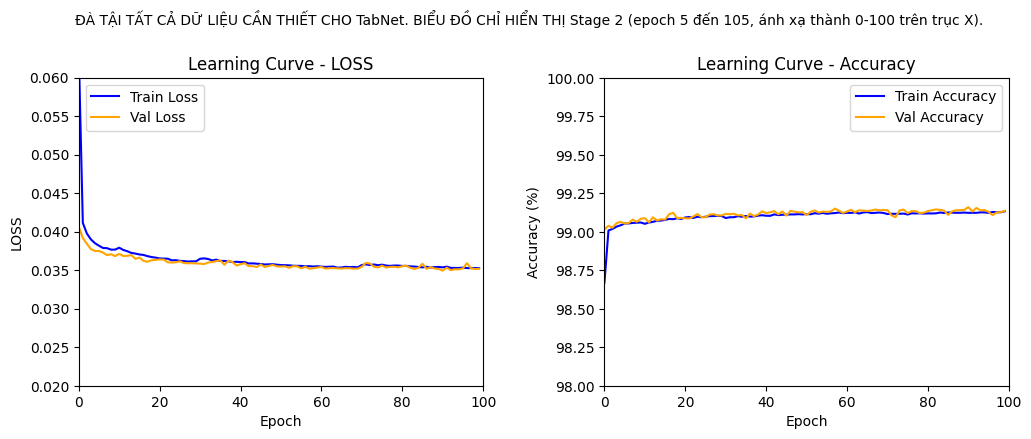

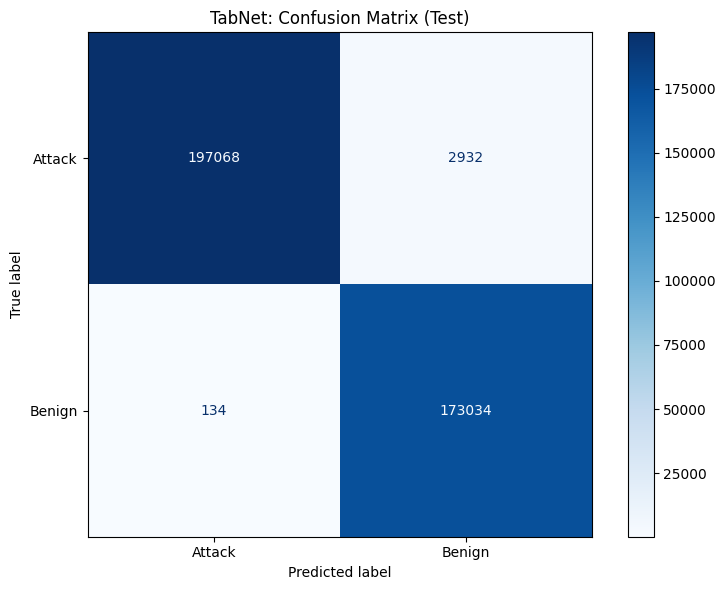

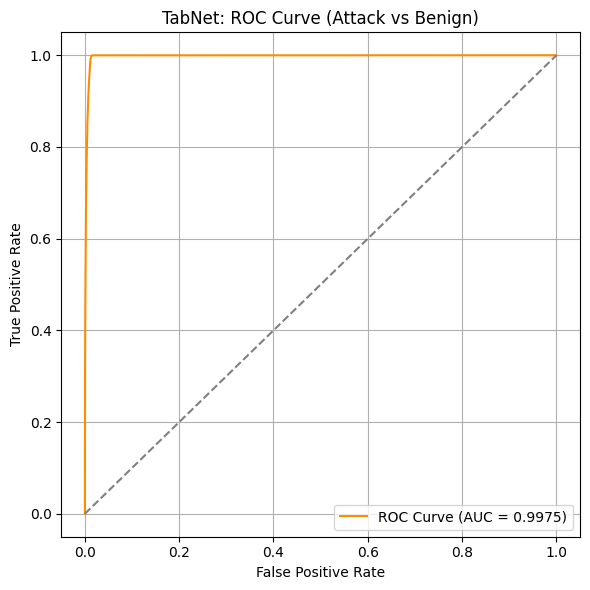

📈 ROC-AUC Score (Attack vs Benign): 0.9975
Shape of test_features: (373168, 2)
PCA failed: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'
Consider increasing the number of samples or features.
⏱️ Thời gian huấn luyện trung bình mỗi epoch: 44.71 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0364
Val Loss trung bình: 0.0359
Train Accuracy trung bình: 99.10%
Val Accuracy trung bình: 99.11%


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_no_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho TabNet")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột, kích thước 12x4

# Biểu đồ Loss (bên trái) - Trục Y từ 0.02 đến 0.06
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("LOSS")
ax1.set_title("Learning Curve - LOSS")
ax1.legend(loc="upper left")
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax1.set_ylim(0.02, 0.06)  # Trục Y từ 0.02 đến 0.06

# Biểu đồ Accuracy (bên phải) - Thu hẹp trục Y để làm rõ dao động
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Learning Curve - Accuracy")
ax2.legend(loc="upper right")
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax2.set_ylim(98, 100)  # Thu hẹp trục Y từ 98% đến 100% để làm rõ dao động

# Thêm ghi chú phía trên biểu đồ (cập nhật để phản ánh việc chỉ vẽ Stage 2)
plt.suptitle("ĐÀ TẬI TẤT CẢ DỮ LIỆU CẦN THIẾT CHO TabNet. BIỂU ĐỒ CHỈ HIỂN THỊ Stage 2 (epoch 5 đến 105, ánh xạ thành 0-100 trên trục X).", 
             fontsize=10, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_tabnet_2labels_no_soft_label_input.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("TabNet: Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_tabnet_2labels_no_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TabNet: ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_tabnet_2labels_no_soft_label_input.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("TabNet: PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_tabnet_2labels_no_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH AUTOINT 44.44 **

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# AutoInt thuần túy
class AutoInt(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, n_layers=3, n_heads=4, dropout=0.1, ff_dim=512):
        super(AutoInt, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout
        self.ff_dim = ff_dim

        # BatchNorm đầu vào
        self.bn = nn.BatchNorm1d(input_dim)

        # Embedding layer
        self.embedding = nn.Linear(input_dim, embed_dim)
        nn.init.xavier_normal_(self.embedding.weight)

        # Multi-head self-attention layers
        self.attn_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embed_dim, num_heads=n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])

        # Feed-forward layers
        self.ff_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, ff_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ff_dim, embed_dim),
                nn.Dropout(dropout)
            )
            for _ in range(n_layers)
        ])

        # Layer normalization
        self.layer_norms1 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.layer_norms2 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(embed_dim, num_classes)  # Dùng trong Stage 2
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        # BatchNorm đầu vào
        x = torch.clamp(self.bn(x), -50, 50)

        # Embedding
        x = self.embedding(x)  # [batch_size, embed_dim]
        x = x.unsqueeze(0)     # [1, batch_size, embed_dim] cho MultiheadAttention

        # Các lớp self-attention và feed-forward
        for i in range(self.n_layers):
            # Self-attention
            attn_output, _ = self.attn_layers[i](x, x, x)
            x = self.layer_norms1[i](x + attn_output)  # Residual connection

            # Feed-forward
            ff_output = self.ff_layers[i](x.transpose(0, 1).contiguous().view(-1, self.embed_dim))
            ff_output = ff_output.view(-1, 1, self.embed_dim).transpose(0, 1)
            x = self.layer_norms2[i](x + ff_output)  # Residual connection

        # Chuyển về dạng [batch_size, embed_dim]
        x = x.squeeze(0)

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(x)
        else:  # stage == 'classification'
            output = self.fc_output(x)

        # AutoInt không dùng sparsity loss hay masks
        sparsity_loss = torch.tensor(0.0, device=x.device)
        masks = []

        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels từ XGBoost (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir}")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")

# Feature Augmentation: Nối soft labels vào input
X_train_aug = np.concatenate([X_train_scaled, soft_labels_train], axis=1)
X_val_aug = np.concatenate([X_val_scaled, soft_labels_val], axis=1)
X_test_aug = np.concatenate([X_test_scaled, soft_labels_test], axis=1)
tqdm.write(f"✅ Đã nối soft labels, shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 10 đặc trưng + 2 soft labels = 12
model = AutoInt(input_dim=input_dim, num_classes=2, embed_dim=192, n_layers=3, n_heads=4).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()  # Dùng cho phân loại nhị phân
criterion_contrast = ContrastiveLoss(margin=1.0)

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Two-Stage Training
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.5
temperature = 2.0

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)  # Không tính accuracy trong Stage 1
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅্র:✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL Loss
tqdm.write("Stage 2: Classification with BCE + KL Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            # Chuyển Y_batch thành one-hot cho BCEWithLogitsLoss
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss
            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)  # Chỉ 2 nhãn
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    # Lưu mô hình tốt nhất dựa trên F1
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/autoint_2labels.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/autoint_2labels_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/autoint_2labels_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels.npy", np.array(epoch_times))
total_time = sum(epoch_times)
np.save(f"{results_dir}/total_time_2labels.npy", np.array([total_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/autoint_2labels.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            probs = torch.softmax(outputs, dim=1)
            test_probs.extend(probs.cpu().numpy())
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(outputs.detach().cpu().numpy())  # Lưu logits
            test_masks.extend(masks)  # AutoInt không có masks, danh sách rỗng
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

# Chuyển thành numpy array
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

# Tính toán các chỉ số
pred_counts = np.bincount(test_preds, minlength=2)  # Chỉ 2 nhãn
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

# Lưu dữ liệu cho biểu đồ
avg_mask = np.zeros((batch_size, input_dim))  # AutoInt không có masks
np.save(f"{results_dir}/confusion_matrix_test_2labels.npy", cm)
np.save(f"{results_dir}/test_probs_2labels.npy", np.array(test_probs))
np.save(f"{results_dir}/test_labels_2labels.npy", np.array(test_labels))
np.save(f"{results_dir}/test_features_2labels.npy", np.array(test_features))
np.save(f"{results_dir}/feature_importance_2labels.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

**VẼ CÁC SƠ ĐỒ**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu
train_losses = np.load(f"{results_dir}/train_losses_2labels.npy")
val_losses = np.load(f"{results_dir}/val_losses_2labels.npy")
train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels.npy")
val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels.npy")
epoch_times = np.load(f"{results_dir}/epoch_times_2labels.npy")
test_labels = np.load(f"{results_dir}/test_labels_2labels.npy")
test_probs = np.load(f"{results_dir}/test_probs_2labels.npy")
test_features = np.load(f"{results_dir}/test_features_2labels.npy")
cm = np.load(f"{results_dir}/confusion_matrix_test_2labels.npy")
feature_importance = np.load(f"{results_dir}/feature_importance_2labels.npy")
epochs = np.arange(len(train_losses))

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ Loss (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Train Loss", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_losses, label="Val Loss", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Validation Loss (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)  # Thêm lưới chính và phụ
# Thu hẹp trục y để phóng to vùng dao động
plt.ylim(0.015, 0.040)  # Loss dao động từ 0.0168 đến 0.0371
plt.minorticks_on()  # Bật lưới phụ
plt.tight_layout()
plt.savefig(f"{results_dir}/loss_plot_2labels_enhanced.png")
plt.show()

# 2️⃣ Accuracy (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_accuracies, label="Val Accuracy", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)  # Thêm lưới chính và phụ
# Thu hẹp trục y để phóng to vùng dao động
plt.ylim(99.2, 99.6)  # Accuracy dao động từ 99.27% đến 99.59%
plt.minorticks_on()  # Bật lưới phụ
plt.tight_layout()
plt.savefig(f"{results_dir}/accuracy_plot_2labels_enhanced.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_2labels.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])  # Xác suất của nhãn 1 (Benign)
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_2labels.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")

# Pad features if n_features < 3
n_samples, n_features = test_features.shape
if n_features < 3:
    print(f"Warning: Only {n_features} features available. Padding to 3 features.")
    padding = np.zeros((n_samples, 3 - n_features))
    test_features_padded = np.hstack((test_features, padding))
else:
    test_features_padded = test_features

# Check if n_samples is sufficient
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. 3D PCA may not be meaningful.")
    # Optionally, skip PCA or warn user
    # For now, proceed but note limitations

# Apply PCA with n_components=3
pca = PCA(n_components=3)
try:
    pca_result = pca.fit_transform(test_features_padded)
    
    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(test_labels):
        idx = test_labels == label
        ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                   label=label_map[label], alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("PCA 3D Visualization (Attack vs Benign)")
    ax.legend(title="Classes")
    plt.tight_layout()
    plt.savefig(f"{results_dir}/pca_3d_2labels.png")
    plt.show()
except ValueError as e:
    print(f"PCA failed: {e}")
    print("Consider increasing the number of samples or features.")

# # 6️⃣ t-SNE 3D
# tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
# tsne_result = tsne.fit_transform(test_features)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Tách dữ liệu theo nhãn để vẽ riêng và gán nhãn trong chú thích
# for label in np.unique(test_labels):
#     idx = test_labels == label
#     ax.scatter(tsne_result[idx, 0], tsne_result[idx, 1], tsne_result[idx, 2], 
#                label=label_map[label], alpha=0.7)

# ax.set_xlabel("t-SNE1")
# ax.set_ylabel("t-SNE2")
# ax.set_zlabel("t-SNE3")
# ax.set_title("t-SNE 3D Visualization (Attack vs Benign)")
# ax.legend(title="Classes")
# plt.tight_layout()
# plt.savefig(f"{results_dir}/tsne_3d_2labels.png")
# plt.show()

# # 7️⃣ Feature Importance
# plt.figure(figsize=(10, 5))
# plt.bar(range(len(feature_importance[0])), feature_importance[0], color='tab:purple')
# plt.xlabel("Feature Index")
# plt.ylabel("Importance Score")
# plt.title("Feature Importance")
# plt.grid(True, axis='y')
# plt.tight_layout()
# plt.savefig(f"{results_dir}/feature_importance_2labels.png")
# plt.show()

# 8️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# **MÔ HÌNH NODE-GAM 57.31 giây**

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 55.55 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0378
Val Loss trung bình: 0.0370
Train Accuracy trung bình: 99.05%
Val Accuracy trung bình: 99.08%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# NODE-GAM (đã điều chỉnh)
class NODEGAM(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_trees=10, depth=6, num_layers=2, dropout=0.1):
        super(NODEGAM, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_trees = num_trees
        self.depth = depth
        self.num_layers = num_layers
        self.dropout = dropout

        # BatchNorm đầu vào
        self.bn = nn.BatchNorm1d(input_dim)

        # Tạo mạng GAM-like cho từng đặc trưng
        self.feature_dim = embed_dim // input_dim  # Kích thước đầu ra mỗi đặc trưng
        self.feature_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(self.feature_dim, self.feature_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for _ in range(input_dim)
        ])

        # Tính kích thước sau khi nối
        self.concat_dim = self.feature_dim * input_dim
        # Lớp chiếu để điều chỉnh về embed_dim
        self.feature_projection = nn.Linear(self.concat_dim, embed_dim)

        # NODE-inspired oblivious decision trees
        self.tree_layers = nn.ModuleList([
            nn.ModuleList([
                nn.Linear(embed_dim, 2**depth)  # Mỗi cây có 2^depth lá
                for _ in range(num_trees)
            ]) for _ in range(num_layers)
        ])

        # Lớp chiếu cho đầu ra của cây
        self.tree_projections = nn.ModuleList([
            nn.Linear(2**depth, embed_dim) for _ in range(num_layers)
        ])

        # Layer normalization
        self.layer_norms = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(num_layers)])

        # Lớp cuối để tạo embedding (Stage 1) hoặc logits (Stage 2)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)  # Dùng trong Stage 1
        self.fc_output = nn.Linear(embed_dim, num_classes)  # Dùng trong Stage 2

        # Khởi tạo trọng số
        for net in self.feature_nets:
            for layer in net:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_normal_(layer.weight)
        for tree_layer in self.tree_layers:
            for tree in tree_layer:
                nn.init.xavier_normal_(tree.weight)
        nn.init.xavier_normal_(self.feature_projection.weight)
        for proj in self.tree_projections:
            nn.init.xavier_normal_(proj.weight)
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        # BatchNorm đầu vào
        x = torch.clamp(self.bn(x), -50, 50)

        # Xử lý từng đặc trưng độc lập (GAM)
        feature_outputs = []
        for i in range(self.input_dim):
            feat = x[:, i:i+1]  # Lấy đặc trưng thứ i
            feat_out = self.feature_nets[i](feat)
            feature_outputs.append(feat_out)
        x = torch.cat(feature_outputs, dim=1)  # Shape: [batch_size, concat_dim]

        # Chiếu về embed_dim
        x = self.feature_projection(x)  # Shape: [batch_size, embed_dim]

        # NODE: Oblivious Decision Trees
        for layer_idx in range(self.num_layers):
            tree_outputs = []
            for tree in self.tree_layers[layer_idx]:
                logits = tree(x)
                probs = F.softmax(logits, dim=-1)
                tree_outputs.append(probs)
            tree_out = torch.stack(tree_outputs, dim=1).mean(dim=1)  # Shape: [batch_size, 2^depth]
            tree_out = self.tree_projections[layer_idx](tree_out)  # Shape: [batch_size, embed_dim]
            x = self.layer_norms[layer_idx](x + tree_out)

        # Tạo embedding (Stage 1) hoặc logits (Stage 2)
        if stage == 'feature_learning':
            output = self.fc_embed(x)
        else:  # stage == 'classification'
            output = self.fc_output(x)

        # NODE-GAM không dùng sparsity loss hay masks
        sparsity_loss = torch.tensor(0.0, device=x.device)
        masks = []

        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir} (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")
if soft_labels_train.shape[1] != 2:
    raise ValueError(f"Soft labels phải có 2 cột (cho 2 nhãn), nhưng có {soft_labels_train.shape[1]} cột")

# Không nối soft labels vào đầu vào (giống các mô hình khác)
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled
tqdm.write(f"✅ Input shape (không nối soft labels): train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình và tối ưu hóa
input_dim = X_train_aug.shape[1]  # 10 đặc trưng
model = NODEGAM(input_dim=input_dim, num_classes=2, embed_dim=192, num_trees=10, depth=6, num_layers=2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_contrast = ContrastiveLoss(margin=1.0)

# Tham số huấn luyện
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.05  # Giảm từ 0.1 xuống 0.05 để giảm ảnh hưởng của soft labels
temperature = 5.0  # Tăng từ 2.0 lên 5.0 để làm mềm phân phối xác suất

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
torch.manual_seed(43)  # Đặt seed khác với FT-Transformer (42) để tạo sự khác biệt
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Tính accuracy trong Stage 1
            with torch.no_grad():
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation trong Stage 1
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, _ in pbar_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs, _, _ = model(X_batch, stage='classification')
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                # Tính contrastive loss để báo cáo (không dùng để tối ưu)
                idx_val = torch.randperm(X_batch.size(0))
                X_batch_2 = X_batch[idx_val]
                Y_batch_2 = Y_batch[idx_val]
                label = (Y_batch == Y_batch_2).float()
                features, _, _ = model(X_batch, stage='feature_learning')
                features_2, _, _ = model(X_batch_2, stage='feature_learning')
                loss = criterion_contrast(features, features_2, label)
                running_val_loss += loss.item() * X_batch.size(0)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

# Stage 2: Classification with BCE + KL Loss
tqdm.write("Stage 2: Classification with BCE + KL Loss (Reduced Soft Label Influence)")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/nodegam_2labels_no_soft_label_input.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/nodegam_2labels_no_soft_label_input_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/nodegam_2labels_no_soft_label_input_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_2labels_no_soft_label_input.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_2labels_no_soft_label_input.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test trên tập test
model.load_state_dict(torch.load(f"{results_dir}/nodegam_2labels_no_soft_label_input.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            embed_features, _, _ = model(X_batch, stage='feature_learning')
            probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(embed_features.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            test_masks.extend(masks)
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=2)
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

avg_mask = np.zeros((batch_size, input_dim))
np.save(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy", cm)
np.save(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels_no_soft_label_input.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels_no_soft_label_input.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)
✅ Đã tải soft labels từ results (2 nhãn)
✅ Input shape (không nối soft labels): train (1212796, 10), val (279876, 10), test (373168, 10)
📡 Thiết bị: cuda
Stage 1: Feature Learning with Contrastive Loss


✅ Epoch 1/5, Train Loss: 0.6990, Val Loss: 0.2162, Train Acc: 54.02%, Val Acc: 53.61%, Time: 90.12s


✅ Epoch 2/5, Train Loss: 0.1268, Val Loss: 0.2145, Train Acc: 53.64%, Val Acc: 53.60%, Time: 89.87s


✅ Epoch 3/5, Train Loss: 0.1266, Val Loss: 0.2128, Train Acc: 53.62%, Val Acc: 53.60%, Time: 90.20s


✅ Epoch 4/5, Train Loss: 0.1264, Val Loss: 0.2122, Train Acc: 53.61%, Val Acc: 53.60%, Time: 89.60s


✅ Epoch 5/5, Train Loss: 0.1263, Val Loss: 0.2122, Train Acc: 53.60%, Val Acc: 53.60%, Time: 90.01s
Stage 2: Classification with BCE + KL Loss (Reduced Soft Label Influence)


✅ Epoch 1/100: Train Loss: 0.0674, Val Loss: 0.0432, Train Acc: 98.25%, Val Acc: 98.98%, F1: 0.9898, Precision: 0.9900, Recall: 0.9898, Time: 53.96s
Phân bố dự đoán (Validation): [147160 132716]
Confusion Matrix:
[[147156   2844]
 [     4 129872]]
📦 Lưu mô hình tốt nhất tại epoch 1


✅ Epoch 2/100: Train Loss: 0.0434, Val Loss: 0.0419, Train Acc: 98.98%, Val Acc: 98.98%, F1: 0.9898, Precision: 0.9900, Recall: 0.9898, Time: 54.10s
Phân bố dự đoán (Validation): [147161 132715]
Confusion Matrix:
[[147157   2843]
 [     4 129872]]
📦 Lưu mô hình tốt nhất tại epoch 2


✅ Epoch 3/100: Train Loss: 0.0422, Val Loss: 0.0412, Train Acc: 98.99%, Val Acc: 98.98%, F1: 0.9898, Precision: 0.9901, Recall: 0.9898, Time: 54.01s
Phân bố dự đoán (Validation): [147156 132720]
Confusion Matrix:
[[147156   2844]
 [     0 129876]]
📦 Lưu mô hình tốt nhất tại epoch 3


✅ Epoch 4/100: Train Loss: 0.0417, Val Loss: 0.0408, Train Acc: 99.00%, Val Acc: 98.99%, F1: 0.9899, Precision: 0.9901, Recall: 0.9899, Time: 53.59s
Phân bố dự đoán (Validation): [147163 132713]
Confusion Matrix:
[[147162   2838]
 [     1 129875]]
📦 Lưu mô hình tốt nhất tại epoch 4


✅ Epoch 5/100: Train Loss: 0.0412, Val Loss: 0.0409, Train Acc: 99.00%, Val Acc: 98.99%, F1: 0.9899, Precision: 0.9901, Recall: 0.9899, Time: 53.76s
Phân bố dự đoán (Validation): [147192 132684]
Confusion Matrix:
[[147186   2814]
 [     6 129870]]
📦 Lưu mô hình tốt nhất tại epoch 5


✅ Epoch 6/100: Train Loss: 0.0409, Val Loss: 0.0406, Train Acc: 99.01%, Val Acc: 99.00%, F1: 0.9900, Precision: 0.9902, Recall: 0.9900, Time: 54.08s
Phân bố dự đoán (Validation): [147233 132643]
Confusion Matrix:
[[147221   2779]
 [    12 129864]]
📦 Lưu mô hình tốt nhất tại epoch 6


✅ Epoch 7/100: Train Loss: 0.0407, Val Loss: 0.0406, Train Acc: 99.01%, Val Acc: 99.00%, F1: 0.9900, Precision: 0.9902, Recall: 0.9900, Time: 53.99s
Phân bố dự đoán (Validation): [147221 132655]
Confusion Matrix:
[[147208   2792]
 [    13 129863]]


✅ Epoch 8/100: Train Loss: 0.0407, Val Loss: 0.0408, Train Acc: 99.01%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 53.56s
Phân bố dự đoán (Validation): [147250 132626]
Confusion Matrix:
[[147235   2765]
 [    15 129861]]
📦 Lưu mô hình tốt nhất tại epoch 8


✅ Epoch 9/100: Train Loss: 0.0406, Val Loss: 0.0405, Train Acc: 99.01%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 53.66s
Phân bố dự đoán (Validation): [147254 132622]
Confusion Matrix:
[[147240   2760]
 [    14 129862]]
📦 Lưu mô hình tốt nhất tại epoch 9


✅ Epoch 10/100: Train Loss: 0.0406, Val Loss: 0.0405, Train Acc: 99.01%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 54.14s
Phân bố dự đoán (Validation): [147256 132620]
Confusion Matrix:
[[147241   2759]
 [    15 129861]]


✅ Epoch 11/100: Train Loss: 0.0405, Val Loss: 0.0409, Train Acc: 99.01%, Val Acc: 99.02%, F1: 0.9902, Precision: 0.9904, Recall: 0.9902, Time: 54.14s
Phân bố dự đoán (Validation): [147306 132570]
Confusion Matrix:
[[147279   2721]
 [    27 129849]]
📦 Lưu mô hình tốt nhất tại epoch 11


✅ Epoch 12/100: Train Loss: 0.0404, Val Loss: 0.0397, Train Acc: 99.01%, Val Acc: 99.01%, F1: 0.9901, Precision: 0.9903, Recall: 0.9901, Time: 53.55s
Phân bố dự đoán (Validation): [147257 132619]
Confusion Matrix:
[[147243   2757]
 [    14 129862]]


✅ Epoch 13/100: Train Loss: 0.0401, Val Loss: 0.0404, Train Acc: 99.01%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 54.28s
Phân bố dự đoán (Validation): [147343 132533]
Confusion Matrix:
[[147315   2685]
 [    28 129848]]
📦 Lưu mô hình tốt nhất tại epoch 13


✅ Epoch 14/100: Train Loss: 0.0398, Val Loss: 0.0394, Train Acc: 99.02%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 54.10s
Phân bố dự đoán (Validation): [147403 132473]
Confusion Matrix:
[[147361   2639]
 [    42 129834]]
📦 Lưu mô hình tốt nhất tại epoch 14


✅ Epoch 15/100: Train Loss: 0.0396, Val Loss: 0.0398, Train Acc: 99.02%, Val Acc: 99.03%, F1: 0.9903, Precision: 0.9905, Recall: 0.9903, Time: 53.57s
Phân bố dự đoán (Validation): [147308 132568]
Confusion Matrix:
[[147291   2709]
 [    17 129859]]


✅ Epoch 16/100: Train Loss: 0.0393, Val Loss: 0.0390, Train Acc: 99.02%, Val Acc: 99.03%, F1: 0.9904, Precision: 0.9905, Recall: 0.9903, Time: 53.98s
Phân bố dự đoán (Validation): [147337 132539]
Confusion Matrix:
[[147318   2682]
 [    19 129857]]


✅ Epoch 17/100: Train Loss: 0.0390, Val Loss: 0.0387, Train Acc: 99.03%, Val Acc: 99.03%, F1: 0.9904, Precision: 0.9905, Recall: 0.9903, Time: 53.66s
Phân bố dự đoán (Validation): [147353 132523]
Confusion Matrix:
[[147326   2674]
 [    27 129849]]


✅ Epoch 18/100: Train Loss: 0.0387, Val Loss: 0.0379, Train Acc: 99.03%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9906, Recall: 0.9905, Time: 53.69s
Phân bố dự đoán (Validation): [147380 132496]
Confusion Matrix:
[[147355   2645]
 [    25 129851]]
📦 Lưu mô hình tốt nhất tại epoch 18


✅ Epoch 19/100: Train Loss: 0.0386, Val Loss: 0.0377, Train Acc: 99.04%, Val Acc: 99.04%, F1: 0.9905, Precision: 0.9906, Recall: 0.9904, Time: 53.98s
Phân bố dự đoán (Validation): [147380 132496]
Confusion Matrix:
[[147353   2647]
 [    27 129849]]


✅ Epoch 20/100: Train Loss: 0.0385, Val Loss: 0.0379, Train Acc: 99.03%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 53.98s
Phân bố dự đoán (Validation): [147379 132497]
Confusion Matrix:
[[147351   2649]
 [    28 129848]]


✅ Epoch 21/100: Train Loss: 0.0383, Val Loss: 0.0381, Train Acc: 99.04%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9905, Recall: 0.9904, Time: 54.03s
Phân bố dự đoán (Validation): [147314 132562]
Confusion Matrix:
[[147307   2693]
 [     7 129869]]


✅ Epoch 22/100: Train Loss: 0.0381, Val Loss: 0.0383, Train Acc: 99.04%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 53.65s
Phân bố dự đoán (Validation): [147391 132485]
Confusion Matrix:
[[147370   2630]
 [    21 129855]]
📦 Lưu mô hình tốt nhất tại epoch 22


✅ Epoch 23/100: Train Loss: 0.0381, Val Loss: 0.0381, Train Acc: 99.04%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9906, Recall: 0.9905, Time: 53.91s
Phân bố dự đoán (Validation): [147394 132482]
Confusion Matrix:
[[147362   2638]
 [    32 129844]]


✅ Epoch 24/100: Train Loss: 0.0379, Val Loss: 0.0386, Train Acc: 99.04%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 53.70s
Phân bố dự đoán (Validation): [147396 132480]
Confusion Matrix:
[[147352   2648]
 [    44 129832]]


✅ Epoch 25/100: Train Loss: 0.0380, Val Loss: 0.0383, Train Acc: 99.04%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 54.25s
Phân bố dự đoán (Validation): [147341 132535]
Confusion Matrix:
[[147327   2673]
 [    14 129862]]


✅ Epoch 26/100: Train Loss: 0.0380, Val Loss: 0.0374, Train Acc: 99.04%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 54.04s
Phân bố dự đoán (Validation): [147376 132500]
Confusion Matrix:
[[147362   2638]
 [    14 129862]]


✅ Epoch 27/100: Train Loss: 0.0378, Val Loss: 0.0376, Train Acc: 99.04%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9906, Recall: 0.9905, Time: 53.99s
Phân bố dự đoán (Validation): [147356 132520]
Confusion Matrix:
[[147342   2658]
 [    14 129862]]


✅ Epoch 28/100: Train Loss: 0.0379, Val Loss: 0.0374, Train Acc: 99.04%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 53.64s
Phân bố dự đoán (Validation): [147377 132499]
Confusion Matrix:
[[147362   2638]
 [    15 129861]]


✅ Epoch 29/100: Train Loss: 0.0379, Val Loss: 0.0381, Train Acc: 99.04%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 53.90s
Phân bố dự đoán (Validation): [147361 132515]
Confusion Matrix:
[[147343   2657]
 [    18 129858]]


✅ Epoch 30/100: Train Loss: 0.0379, Val Loss: 0.0377, Train Acc: 99.04%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9906, Recall: 0.9905, Time: 53.61s
Phân bố dự đoán (Validation): [147358 132518]
Confusion Matrix:
[[147344   2656]
 [    14 129862]]


✅ Epoch 31/100: Train Loss: 0.0380, Val Loss: 0.0384, Train Acc: 99.04%, Val Acc: 99.04%, F1: 0.9904, Precision: 0.9906, Recall: 0.9904, Time: 54.23s
Phân bố dự đoán (Validation): [147357 132519]
Confusion Matrix:
[[147339   2661]
 [    18 129858]]


✅ Epoch 32/100: Train Loss: 0.0378, Val Loss: 0.0373, Train Acc: 99.05%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 53.57s
Phân bố dự đoán (Validation): [147369 132507]
Confusion Matrix:
[[147351   2649]
 [    18 129858]]


✅ Epoch 33/100: Train Loss: 0.0378, Val Loss: 0.0376, Train Acc: 99.05%, Val Acc: 99.05%, F1: 0.9905, Precision: 0.9907, Recall: 0.9905, Time: 54.04s
Phân bố dự đoán (Validation): [147418 132458]
Confusion Matrix:
[[147382   2618]
 [    36 129840]]


✅ Epoch 34/100: Train Loss: 0.0375, Val Loss: 0.0367, Train Acc: 99.05%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9909, Recall: 0.9907, Time: 53.65s
Phân bố dự đoán (Validation): [147449 132427]
Confusion Matrix:
[[147429   2571]
 [    20 129856]]
📦 Lưu mô hình tốt nhất tại epoch 34


✅ Epoch 35/100: Train Loss: 0.0376, Val Loss: 0.0364, Train Acc: 99.05%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 53.94s
Phân bố dự đoán (Validation): [147506 132370]
Confusion Matrix:
[[147483   2517]
 [    23 129853]]
📦 Lưu mô hình tốt nhất tại epoch 35


✅ Epoch 39/100: Train Loss: 0.0371, Val Loss: 0.0366, Train Acc: 99.07%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 53.52s
Phân bố dự đoán (Validation): [147483 132393]
Confusion Matrix:
[[147460   2540]
 [    23 129853]]


✅ Epoch 40/100: Train Loss: 0.0371, Val Loss: 0.0362, Train Acc: 99.07%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 53.87s
Phân bố dự đoán (Validation): [147534 132342]
Confusion Matrix:
[[147504   2496]
 [    30 129846]]
📦 Lưu mô hình tốt nhất tại epoch 40


✅ Epoch 41/100: Train Loss: 0.0371, Val Loss: 0.0364, Train Acc: 99.07%, Val Acc: 99.07%, F1: 0.9907, Precision: 0.9908, Recall: 0.9907, Time: 53.70s
Phân bố dự đoán (Validation): [147429 132447]
Confusion Matrix:
[[147408   2592]
 [    21 129855]]


✅ Epoch 42/100: Train Loss: 0.0371, Val Loss: 0.0362, Train Acc: 99.06%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 54.06s
Phân bố dự đoán (Validation): [147577 132299]
Confusion Matrix:
[[147538   2462]
 [    39 129837]]
📦 Lưu mô hình tốt nhất tại epoch 42


✅ Epoch 43/100: Train Loss: 0.0369, Val Loss: 0.0360, Train Acc: 99.07%, Val Acc: 99.08%, F1: 0.9909, Precision: 0.9910, Recall: 0.9908, Time: 54.12s
Phân bố dự đoán (Validation): [147498 132378]
Confusion Matrix:
[[147468   2532]
 [    30 129846]]


✅ Epoch 44/100: Train Loss: 0.0368, Val Loss: 0.0370, Train Acc: 99.07%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9909, Recall: 0.9908, Time: 53.73s
Phân bố dự đoán (Validation): [147456 132420]
Confusion Matrix:
[[147434   2566]
 [    22 129854]]


✅ Epoch 45/100: Train Loss: 0.0368, Val Loss: 0.0363, Train Acc: 99.07%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 54.07s
Phân bố dự đoán (Validation): [147506 132370]
Confusion Matrix:
[[147477   2523]
 [    29 129847]]


✅ Epoch 46/100: Train Loss: 0.0368, Val Loss: 0.0362, Train Acc: 99.08%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9910, Recall: 0.9909, Time: 53.80s
Phân bố dự đoán (Validation): [147496 132380]
Confusion Matrix:
[[147471   2529]
 [    25 129851]]


✅ Epoch 47/100: Train Loss: 0.0368, Val Loss: 0.0360, Train Acc: 99.07%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9912, Recall: 0.9910, Time: 54.19s
Phân bố dự đoán (Validation): [147558 132318]
Confusion Matrix:
[[147519   2481]
 [    39 129837]]


✅ Epoch 48/100: Train Loss: 0.0368, Val Loss: 0.0358, Train Acc: 99.06%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 53.65s
Phân bố dự đoán (Validation): [147574 132302]
Confusion Matrix:
[[147542   2458]
 [    32 129844]]
📦 Lưu mô hình tốt nhất tại epoch 48


✅ Epoch 49/100: Train Loss: 0.0366, Val Loss: 0.0365, Train Acc: 99.08%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 53.91s
Phân bố dự đoán (Validation): [147489 132387]
Confusion Matrix:
[[147455   2545]
 [    34 129842]]


✅ Epoch 50/100: Train Loss: 0.0367, Val Loss: 0.0357, Train Acc: 99.07%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 53.58s
Phân bố dự đoán (Validation): [147577 132299]
Confusion Matrix:
[[147549   2451]
 [    28 129848]]
📦 Lưu mô hình tốt nhất tại epoch 50


✅ Epoch 51/100: Train Loss: 0.0366, Val Loss: 0.0366, Train Acc: 99.08%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 53.69s
Phân bố dự đoán (Validation): [147539 132337]
Confusion Matrix:
[[147487   2513]
 [    52 129824]]


✅ Epoch 52/100: Train Loss: 0.0366, Val Loss: 0.0357, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 53.51s
Phân bố dự đoán (Validation): [147551 132325]
Confusion Matrix:
[[147525   2475]
 [    26 129850]]


✅ Epoch 53/100: Train Loss: 0.0365, Val Loss: 0.0361, Train Acc: 99.08%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 53.53s
Phân bố dự đoán (Validation): [147521 132355]
Confusion Matrix:
[[147492   2508]
 [    29 129847]]


✅ Epoch 54/100: Train Loss: 0.0365, Val Loss: 0.0361, Train Acc: 99.08%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9912, Recall: 0.9910, Time: 54.17s
Phân bố dự đoán (Validation): [147584 132292]
Confusion Matrix:
[[147533   2467]
 [    51 129825]]


✅ Epoch 55/100: Train Loss: 0.0365, Val Loss: 0.0358, Train Acc: 99.08%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 53.55s
Phân bố dự đoán (Validation): [147516 132360]
Confusion Matrix:
[[147494   2506]
 [    22 129854]]


✅ Epoch 56/100: Train Loss: 0.0365, Val Loss: 0.0362, Train Acc: 99.08%, Val Acc: 99.09%, F1: 0.9909, Precision: 0.9911, Recall: 0.9909, Time: 53.81s
Phân bố dự đoán (Validation): [147527 132349]
Confusion Matrix:
[[147496   2504]
 [    31 129845]]


✅ Epoch 57/100: Train Loss: 0.0365, Val Loss: 0.0361, Train Acc: 99.07%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 53.69s
Phân bố dự đoán (Validation): [147561 132315]
Confusion Matrix:
[[147518   2482]
 [    43 129833]]


✅ Epoch 58/100: Train Loss: 0.0365, Val Loss: 0.0362, Train Acc: 99.08%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 54.31s
Phân bố dự đoán (Validation): [147486 132390]
Confusion Matrix:
[[147460   2540]
 [    26 129850]]


✅ Epoch 59/100: Train Loss: 0.0364, Val Loss: 0.0358, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 53.40s
Phân bố dự đoán (Validation): [147618 132258]
Confusion Matrix:
[[147567   2433]
 [    51 129825]]


✅ Epoch 60/100: Train Loss: 0.0365, Val Loss: 0.0358, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 54.05s
Phân bố dự đoán (Validation): [147577 132299]
Confusion Matrix:
[[147541   2459]
 [    36 129840]]


✅ Epoch 61/100: Train Loss: 0.0365, Val Loss: 0.0357, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 53.63s
Phân bố dự đoán (Validation): [147582 132294]
Confusion Matrix:
[[147556   2444]
 [    26 129850]]
📦 Lưu mô hình tốt nhất tại epoch 61


✅ Epoch 62/100: Train Loss: 0.0364, Val Loss: 0.0355, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 54.07s
Phân bố dự đoán (Validation): [147576 132300]
Confusion Matrix:
[[147551   2449]
 [    25 129851]]


✅ Epoch 63/100: Train Loss: 0.0364, Val Loss: 0.0355, Train Acc: 99.08%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9915, Recall: 0.9913, Time: 53.89s
Phân bố dự đoán (Validation): [147644 132232]
Confusion Matrix:
[[147606   2394]
 [    38 129838]]
📦 Lưu mô hình tốt nhất tại epoch 63


✅ Epoch 64/100: Train Loss: 0.0364, Val Loss: 0.0358, Train Acc: 99.08%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9912, Recall: 0.9910, Time: 54.52s
Phân bố dự đoán (Validation): [147546 132330]
Confusion Matrix:
[[147516   2484]
 [    30 129846]]


✅ Epoch 65/100: Train Loss: 0.0364, Val Loss: 0.0359, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 53.57s
Phân bố dự đoán (Validation): [147572 132304]
Confusion Matrix:
[[147535   2465]
 [    37 129839]]


✅ Epoch 66/100: Train Loss: 0.0363, Val Loss: 0.0359, Train Acc: 99.08%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 53.97s
Phân bố dự đoán (Validation): [147543 132333]
Confusion Matrix:
[[147510   2490]
 [    33 129843]]


✅ Epoch 67/100: Train Loss: 0.0364, Val Loss: 0.0355, Train Acc: 99.08%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9914, Recall: 0.9913, Time: 53.75s
Phân bố dự đoán (Validation): [147617 132259]
Confusion Matrix:
[[147586   2414]
 [    31 129845]]


✅ Epoch 68/100: Train Loss: 0.0364, Val Loss: 0.0361, Train Acc: 99.08%, Val Acc: 99.10%, F1: 0.9910, Precision: 0.9911, Recall: 0.9910, Time: 54.00s
Phân bố dự đoán (Validation): [147558 132318]
Confusion Matrix:
[[147514   2486]
 [    44 129832]]


✅ Epoch 69/100: Train Loss: 0.0364, Val Loss: 0.0355, Train Acc: 99.08%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9914, Recall: 0.9913, Time: 53.51s
Phân bố dự đoán (Validation): [147612 132264]
Confusion Matrix:
[[147585   2415]
 [    27 129849]]


✅ Epoch 70/100: Train Loss: 0.0363, Val Loss: 0.0356, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 53.74s
Phân bố dự đoán (Validation): [147597 132279]
Confusion Matrix:
[[147563   2437]
 [    34 129842]]


✅ Epoch 71/100: Train Loss: 0.0365, Val Loss: 0.0355, Train Acc: 99.08%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9914, Recall: 0.9913, Time: 53.66s
Phân bố dự đoán (Validation): [147661 132215]
Confusion Matrix:
[[147607   2393]
 [    54 129822]]


✅ Epoch 72/100: Train Loss: 0.0366, Val Loss: 0.0355, Train Acc: 99.08%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9914, Recall: 0.9913, Time: 54.01s
Phân bố dự đoán (Validation): [147635 132241]
Confusion Matrix:
[[147596   2404]
 [    39 129837]]


✅ Epoch 73/100: Train Loss: 0.0365, Val Loss: 0.0366, Train Acc: 99.08%, Val Acc: 99.08%, F1: 0.9908, Precision: 0.9910, Recall: 0.9908, Time: 53.61s
Phân bố dự đoán (Validation): [147491 132385]
Confusion Matrix:
[[147464   2536]
 [    27 129849]]


✅ Epoch 74/100: Train Loss: 0.0365, Val Loss: 0.0357, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 54.10s
Phân bố dự đoán (Validation): [147599 132277]
Confusion Matrix:
[[147565   2435]
 [    34 129842]]


✅ Epoch 75/100: Train Loss: 0.0364, Val Loss: 0.0357, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9912, Recall: 0.9911, Time: 53.61s
Phân bố dự đoán (Validation): [147575 132301]
Confusion Matrix:
[[147539   2461]
 [    36 129840]]


✅ Epoch 76/100: Train Loss: 0.0365, Val Loss: 0.0354, Train Acc: 99.08%, Val Acc: 99.13%, F1: 0.9913, Precision: 0.9915, Recall: 0.9913, Time: 53.87s
Phân bố dự đoán (Validation): [147697 132179]
Confusion Matrix:
[[147637   2363]
 [    60 129816]]
📦 Lưu mô hình tốt nhất tại epoch 76


✅ Epoch 77/100: Train Loss: 0.0365, Val Loss: 0.0362, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 53.81s
Phân bố dự đoán (Validation): [147563 132313]
Confusion Matrix:
[[147535   2465]
 [    28 129848]]


✅ Epoch 78/100: Train Loss: 0.0364, Val Loss: 0.0356, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 53.64s
Phân bố dự đoán (Validation): [147573 132303]
Confusion Matrix:
[[147546   2454]
 [    27 129849]]


✅ Epoch 79/100: Train Loss: 0.0365, Val Loss: 0.0360, Train Acc: 99.08%, Val Acc: 99.09%, F1: 0.9910, Precision: 0.9911, Recall: 0.9909, Time: 54.03s
Phân bố dự đoán (Validation): [147511 132365]
Confusion Matrix:
[[147489   2511]
 [    22 129854]]


✅ Epoch 80/100: Train Loss: 0.0364, Val Loss: 0.0356, Train Acc: 99.08%, Val Acc: 99.12%, F1: 0.9912, Precision: 0.9913, Recall: 0.9912, Time: 53.21s
Phân bố dự đoán (Validation): [147615 132261]
Confusion Matrix:
[[147571   2429]
 [    44 129832]]


✅ Epoch 81/100: Train Loss: 0.0364, Val Loss: 0.0357, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 54.02s
Phân bố dự đoán (Validation): [147583 132293]
Confusion Matrix:
[[147547   2453]
 [    36 129840]]


✅ Epoch 82/100: Train Loss: 0.0364, Val Loss: 0.0355, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9912, Precision: 0.9913, Recall: 0.9911, Time: 53.37s
Phân bố dự đoán (Validation): [147603 132273]
Confusion Matrix:
[[147563   2437]
 [    40 129836]]


✅ Epoch 83/100: Train Loss: 0.0364, Val Loss: 0.0358, Train Acc: 99.08%, Val Acc: 99.11%, F1: 0.9911, Precision: 0.9913, Recall: 0.9911, Time: 53.84s
Phân bố dự đoán (Validation): [147592 132284]
Confusion Matrix:
[[147553   2447]
 [    39 129837]]


Validation (Epoch 84):  42%|████▏     | 228/547 [00:02<00:02, 116.00batch/s, val_loss=0.0218]     

**VẼ CÁC SƠ ĐỒ**

✅ Đã tải tất cả dữ liệu cần thiết cho NODE-GAM


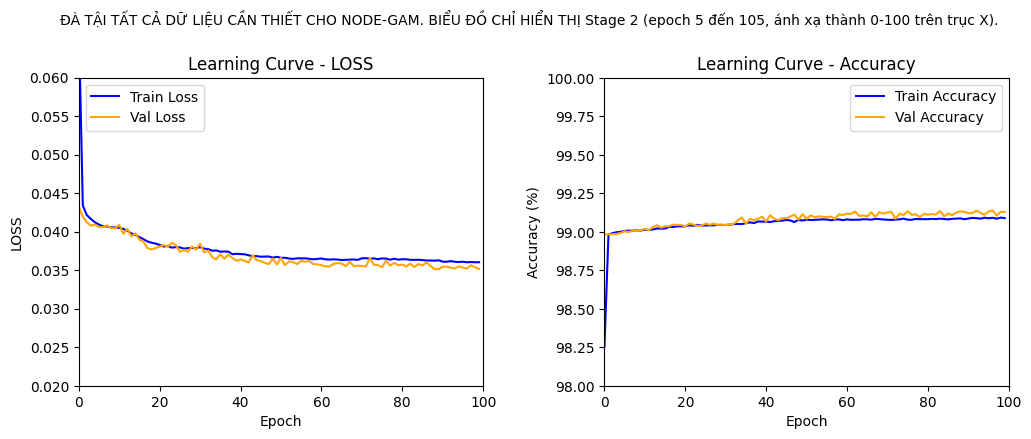

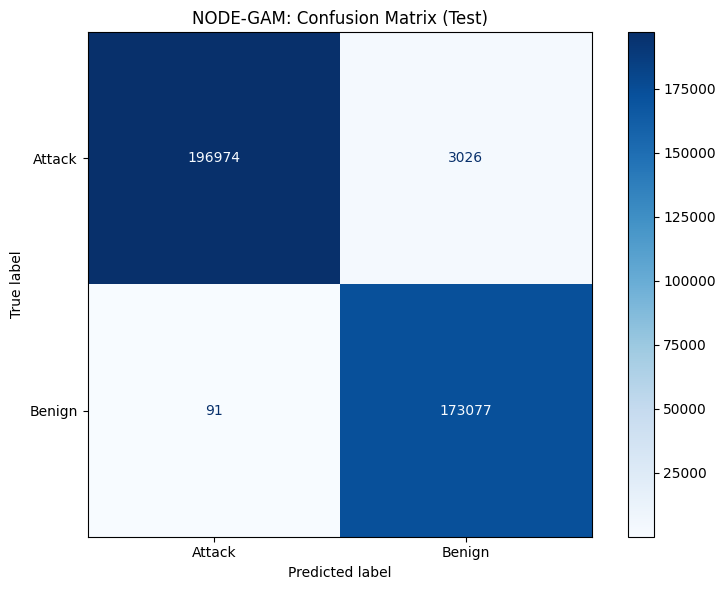

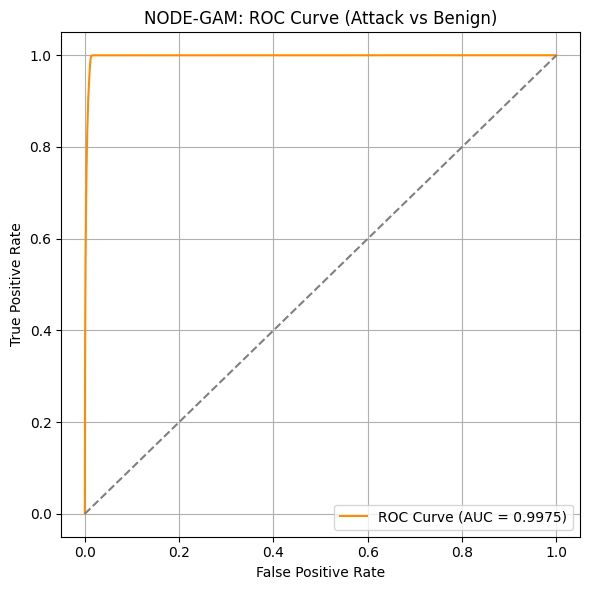

📈 ROC-AUC Score (Attack vs Benign): 0.9975
Shape of test_features: (373168, 192)


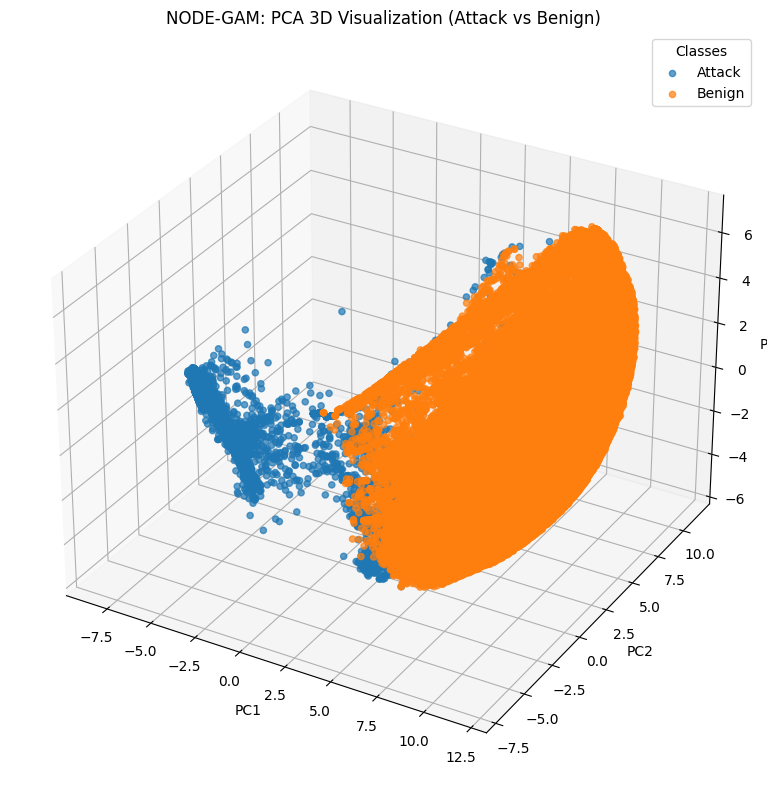

⏱️ Thời gian huấn luyện trung bình mỗi epoch: 55.55 giây

📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):
Train Loss trung bình: 0.0378
Val Loss trung bình: 0.0370
Train Accuracy trung bình: 99.05%
Val Accuracy trung bình: 99.08%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels_no_soft_label_input.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels_no_soft_label_input.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels_no_soft_label_input.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels_no_soft_label_input.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels_no_soft_label_input.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels_no_soft_label_input.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels_no_soft_label_input.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels_no_soft_label_input.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels_no_soft_label_input.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết cho NODE-GAM")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Loại bỏ Stage 1 (5 epoch đầu), chỉ vẽ Stage 2 (epoch 5 đến 105)
stage1_epochs = 5
start_epoch = stage1_epochs  # Bắt đầu từ epoch 5
epochs = np.arange(len(train_losses))
# Lấy dữ liệu từ epoch 5 trở đi (Stage 2)
train_accuracies_plot = train_accuracies[start_epoch:]
val_accuracies_plot = val_accuracies[start_epoch:]
train_losses_plot = train_losses[start_epoch:]
val_losses_plot = val_losses[start_epoch:]
# Ánh xạ epochs từ 5-105 thành 0-100 trên trục X
epochs_mapped = (epochs[start_epoch:] - start_epoch)  # Ánh xạ: epoch 5 → 0, epoch 105 → 100

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ & 2️⃣ Vẽ biểu đồ Loss và Accuracy cạnh nhau
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 hàng, 2 cột, kích thước 12x4

# Biểu đồ Loss (bên trái) - Trục Y từ 0.02 đến 0.06
ax1.plot(epochs_mapped, train_losses_plot, label="Train Loss", linestyle="-", color="blue", linewidth=1.5)
ax1.plot(epochs_mapped, val_losses_plot, label="Val Loss", linestyle="-", color="orange", linewidth=1.5)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("LOSS")
ax1.set_title("Learning Curve - LOSS")
ax1.legend(loc="upper left")
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax1.set_ylim(0.02, 0.06)  # Trục Y từ 0.02 đến 0.06

# Biểu đồ Accuracy (bên phải) - Thu hẹp trục Y để làm rõ dao động
ax2.plot(epochs_mapped, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="blue", linewidth=1.5)
ax2.plot(epochs_mapped, val_accuracies_plot, label="Val Accuracy", linestyle="-", color="orange", linewidth=1.5)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Learning Curve - Accuracy")
ax2.legend(loc="upper right")
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 20))  # 0, 20, 40, 60, 80, 100
ax2.set_ylim(98, 100)  # Thu hẹp trục Y từ 98% đến 100% để làm rõ dao động

# Thêm ghi chú phía trên biểu đồ (cập nhật để phản ánh việc chỉ vẽ Stage 2)
plt.suptitle("ĐÀ TẬI TẤT CẢ DỮ LIỆU CẦN THIẾT CHO NODE-GAM. BIỂU ĐỒ CHỈ HIỂN THỊ Stage 2 (epoch 5 đến 105, ánh xạ thành 0-100 trên trục X).", 
             fontsize=10, y=1.05)

# Điều chỉnh khoảng cách giữa hai biểu đồ
plt.subplots_adjust(wspace=0.3)

# Lưu biểu đồ
plt.savefig(f"{results_dir}/learning_curves_nodegam_2labels_no_soft_label_input.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("NODE-GAM: Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_nodegam_2labels_no_soft_label_input.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("NODE-GAM: ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_nodegam_2labels_no_soft_label_input.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("NODE-GAM: PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_nodegam_2labels_no_soft_label_input.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# 7️⃣ In giá trị trung bình của Loss và Accuracy ở Stage 2
avg_train_loss = np.mean(train_losses_plot)
avg_val_loss = np.mean(val_losses_plot)
avg_train_accuracy = np.mean(train_accuracies_plot)
avg_val_accuracy = np.mean(val_accuracies_plot)

print("\n📊 Giá trị trung bình ở Stage 2 (epoch 5 đến 105):")
print(f"Train Loss trung bình: {avg_train_loss:.4f}")
print(f"Val Loss trung bình: {avg_val_loss:.4f}")
print(f"Train Accuracy trung bình: {avg_train_accuracy:.2f}%")
print(f"Val Accuracy trung bình: {avg_val_accuracy:.2f}%")

# **MÔ HÌNH FT-TRAN 66.70 giây**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import time
from tqdm import tqdm
import os

# Tạo thư mục lưu dữ liệu
output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_positive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2))
        loss_negative = torch.mean(label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return (loss_positive + loss_negative) / 2

# Ghost Batch Normalization
class GhostBN1d(nn.Module):
    def __init__(self, num_features, virtual_batch_size=512):
        super(GhostBN1d, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
        self.virtual_batch_size = virtual_batch_size

    def forward(self, x):
        batch_size = x.size(0)
        if batch_size <= self.virtual_batch_size:
            return self.bn(x)
        n_splits = batch_size // self.virtual_batch_size
        x_splits = torch.split(x, self.virtual_batch_size, dim=0)
        x_splits = [self.bn(split) for split in x_splits[:n_splits]]
        remaining = batch_size % self.virtual_batch_size
        if remaining > 0:
            x_splits.append(self.bn(x[-remaining:]))
        return torch.cat(x_splits, dim=0)

# FT-Transformer
class FTTransformerPure(nn.Module):
    def __init__(self, input_dim, num_classes, embed_dim=192, num_layers=6, num_heads=4, ff_hidden_dim=768, dropout=0.1):
        super(FTTransformerPure, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.ff_hidden_dim = ff_hidden_dim
        self.dropout = dropout

        self.bn = GhostBN1d(input_dim, virtual_batch_size=512)
        self.feature_embed = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_hidden_dim, dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc_embed = nn.Linear(embed_dim, embed_dim)
        self.fc_output = nn.Linear(embed_dim, num_classes)

        nn.init.xavier_normal_(self.feature_embed.weight)
        nn.init.xavier_normal_(self.fc_embed.weight)
        nn.init.xavier_normal_(self.fc_output.weight)
        nn.init.zeros_(self.feature_embed.bias)
        nn.init.zeros_(self.fc_embed.bias)
        nn.init.zeros_(self.fc_output.bias)

    def forward(self, x, stage='classification'):
        x = torch.clamp(self.bn(x), -50, 50)
        x = self.feature_embed(x)
        x = self.ln(x)
        x = self.transformer(x.unsqueeze(1)).squeeze(1)
        embeddings = self.ln(x)
        if stage == 'feature_learning':
            output = self.fc_embed(embeddings)
        else:
            output = self.fc_output(embeddings)
        sparsity_loss = torch.tensor(0.0, device=x.device)
        masks = []
        return output, sparsity_loss, masks

# Tải dữ liệu (2 nhãn)
try:
    X_train_scaled = np.load(f"{output_dir}/X_train_scaled_2labels.npy")
    Y_train_encoded = np.load(f"{output_dir}/Y_train_encoded_2labels.npy")
    X_val_scaled = np.load(f"{output_dir}/X_val_scaled_2labels.npy")
    Y_val_encoded = np.load(f"{output_dir}/Y_val_encoded_2labels.npy")
    X_test_scaled = np.load(f"{output_dir}/X_test_scaled_2labels.npy")
    Y_test_encoded = np.load(f"{output_dir}/Y_test_encoded_2labels.npy")
    tqdm.write("✅ Đã tải dữ liệu scaled và nhãn (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Tải soft labels (2 nhãn)
try:
    soft_labels_train = np.load(f"{results_dir}/soft_labels_train_2labels.npy")
    soft_labels_val = np.load(f"{results_dir}/soft_labels_val_2labels.npy")
    soft_labels_test = np.load(f"{results_dir}/soft_labels_test_2labels.npy")
    tqdm.write(f"✅ Đã tải soft labels từ {results_dir} (2 nhãn)")
except Exception as e:
    tqdm.write(f"❌ Lỗi khi tải soft labels: {str(e)}")
    raise

# Kiểm tra kích thước soft labels
if soft_labels_train.shape[0] != X_train_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_train ({soft_labels_train.shape[0]}) không khớp với X_train_scaled ({X_train_scaled.shape[0]})")
if soft_labels_val.shape[0] != X_val_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_val ({soft_labels_val.shape[0]}) không khớp với X_val_scaled ({X_val_scaled.shape[0]})")
if soft_labels_test.shape[0] != X_test_scaled.shape[0]:
    raise ValueError(f"Kích thước soft_labels_test ({soft_labels_test.shape[0]}) không khớp với X_test_scaled ({X_test_scaled.shape[0]})")
if soft_labels_train.shape[1] != 2:
    raise ValueError(f"Soft labels phải có 2 cột (cho 2 nhãn), nhưng có {soft_labels_train.shape[1]} cột")

# Không nối soft labels vào đầu vào
X_train_aug = X_train_scaled  # Shape: (n_train, 10)
X_val_aug = X_val_scaled
X_test_aug = X_test_scaled
tqdm.write(f"✅ Input shape: train {X_train_aug.shape}, val {X_val_aug.shape}, test {X_test_aug.shape}")

# Chuyển thành tensor
X_train_tensor = torch.tensor(X_train_aug, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
soft_labels_train_tensor = torch.tensor(soft_labels_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_aug, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
soft_labels_val_tensor = torch.tensor(soft_labels_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_aug, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)

# DataLoader
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor, soft_labels_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor, soft_labels_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.write(f"📡 Thiết bị: {device}")

# Khởi tạo mô hình
input_dim = X_train_aug.shape[1]  # 10 đặc trưng
model = FTTransformerPure(
    input_dim=input_dim,
    num_classes=2,
    embed_dim=192,
    num_layers=6,
    num_heads=4,
    ff_hidden_dim=768,
    dropout=0.1
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_contrast = ContrastiveLoss(margin=1.0)

# Tham số huấn luyện
num_epochs_stage1 = 5
num_epochs_stage2 = 100
distillation_weight = 0.05  # Giảm để giảm ảnh hưởng của soft labels
temperature = 2.0

# Danh sách lưu dữ liệu
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epoch_times = []

# Stage 1: Feature Learning
tqdm.write("Stage 1: Feature Learning with Contrastive Loss")
torch.manual_seed(42)  # Đặt seed cho tái hiện
for epoch in range(num_epochs_stage1):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage1})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, _ in pbar:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            idx = torch.randperm(X_batch.size(0))
            X_batch_2 = X_batch[idx]
            Y_batch_2 = Y_batch[idx]
            label = (Y_batch == Y_batch_2).float()
            features, _, _ = model(X_batch, stage='feature_learning')
            features_2, _, _ = model(X_batch_2, stage='feature_learning')
            loss = criterion_contrast(features, features_2, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(0.0)
    val_losses.append(0.0)
    val_accuracies.append(0.0)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage1}, Train Loss: {train_losses[-1]:.4f}, Time: {epoch_time:.2f}s")

# Stage 2: Classification
tqdm.write("Stage 2: Classification with BCE + KL Loss")
best_f1 = 0
for epoch in range(num_epochs_stage2):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0
    train_preds = []
    train_labels = []
    with tqdm(train_loader, desc=f"Training Batch (Epoch {epoch+1}/{num_epochs_stage2})", unit="batch", leave=False) as pbar:
        for X_batch, Y_batch, soft_labels in pbar:
            X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
            optimizer.zero_grad()
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
            bce_loss = criterion_bce(outputs, Y_batch_onehot)
            kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
            loss = bce_loss + distillation_weight * kl_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(Y_batch.cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    scheduler.step()

    # Validation
    model.eval()
    running_val_loss = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", unit="batch", leave=False) as pbar_val:
            for X_batch, Y_batch, soft_labels in pbar_val:
                X_batch, Y_batch, soft_labels = X_batch.to(device), Y_batch.to(device), soft_labels.to(device)
                outputs, sparsity_loss, _ = model(X_batch, stage='classification')
                Y_batch_onehot = F.one_hot(Y_batch, num_classes=2).float()
                bce_loss = criterion_bce(outputs, Y_batch_onehot)
                kl_loss = torch.clamp(F.kl_div(F.log_softmax(outputs / temperature, dim=1), soft_labels / temperature, reduction='batchmean', log_target=False), min=0.0)
                loss = bce_loss + distillation_weight * kl_loss
                running_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(Y_batch.cpu().numpy())
                pbar_val.set_postfix({"val_loss": f"{loss.item():.4f}"})

    val_loss = running_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds) * 100
    f1 = f1_score(val_labels, val_preds, average='weighted')
    precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_preds, average='weighted')
    cm = confusion_matrix(val_labels, val_preds)

    pred_counts = np.bincount(val_preds, minlength=2)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    tqdm.write(f"✅ Epoch {epoch+1}/{num_epochs_stage2}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Time: {epoch_time:.2f}s")
    tqdm.write(f"Phân bố dự đoán (Validation): {pred_counts}")
    tqdm.write(f"Confusion Matrix:\n{cm}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), f"{results_dir}/fttransformer_2labels.pth")
        tqdm.write(f"📦 Lưu mô hình tốt nhất tại epoch {epoch+1}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), f"{results_dir}/fttransformer_2labels_final.pth")
tqdm.write(f"📦 Lưu mô hình cuối cùng tại {results_dir}/fttransformer_2labels_final.pth")

# Lưu dữ liệu
np.save(f"{results_dir}/train_losses_2labels.npy", np.array(train_losses))
np.save(f"{results_dir}/train_accuracies_2labels.npy", np.array(train_accuracies))
np.save(f"{results_dir}/val_losses_2labels.npy", np.array(val_losses))
np.save(f"{results_dir}/val_accuracies_2labels.npy", np.array(val_accuracies))
np.save(f"{results_dir}/epoch_times_2labels.npy", np.array(epoch_times))
total_time = sum(epoch_times)
avg_epoch_time = total_time / len(epoch_times) if epoch_times else 0
np.save(f"{results_dir}/total_time_2labels.npy", np.array([total_time]))
np.save(f"{results_dir}/avg_epoch_time_2labels.npy", np.array([avg_epoch_time]))
tqdm.write(f"📊 Tổng thời gian huấn luyện: {total_time:.2f}s")
tqdm.write(f"📊 Thời gian huấn luyện trung bình mỗi epoch: {avg_epoch_time:.2f}s")

# Test
model.load_state_dict(torch.load(f"{results_dir}/fttransformer_2labels.pth", weights_only=True))
model.eval()
test_preds = []
test_labels = []
test_features = []
test_probs = []
test_masks = []
with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar_test:
        for X_batch, Y_batch in pbar_test:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs, sparsity_loss, masks = model(X_batch, stage='classification')
            embed_features, _, _ = model(X_batch, stage='feature_learning')
            probs = torch.softmax(outputs, dim=1)
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(Y_batch.cpu().numpy())
            test_features.extend(embed_features.detach().cpu().numpy())
            test_probs.extend(probs.cpu().numpy())
            test_masks.extend(masks)
            pbar_test.set_postfix({"test_loss": f"{sparsity_loss.item():.4f}"})

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_features = np.array(test_features)
test_probs = np.array(test_probs)

pred_counts = np.bincount(test_preds, minlength=2)
test_acc = accuracy_score(test_labels, test_preds) * 100
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted')
cm = confusion_matrix(test_labels, test_preds)

tqdm.write(f"🔍 Kích thước Confusion Matrix (Test): {cm.shape}")
if cm.shape != (2, 2):
    tqdm.write(f"⚠️ Cảnh báo: Kích thước Confusion Matrix không phải (2,2), là {cm.shape}")

tqdm.write(f"\n📊 Kết quả trên tập test:")
tqdm.write(f"Test Acc: {test_acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
tqdm.write(f"Phân bố dự đoán (Test): {pred_counts}")
tqdm.write(f"Confusion Matrix:\n{cm}")

avg_mask = np.zeros((batch_size, input_dim))
np.save(f"{results_dir}/confusion_matrix_test_2labels.npy", cm)
np.save(f"{results_dir}/test_probs_2labels.npy", test_probs)
np.save(f"{results_dir}/test_labels_2labels.npy", test_labels)
np.save(f"{results_dir}/test_features_2labels.npy", test_features)
np.save(f"{results_dir}/feature_importance_2labels.npy", avg_mask)

tqdm.write(f"Train Losses shape: {np.array(train_losses).shape}")
tqdm.write(f"Train Accuracies shape: {np.array(train_accuracies).shape}")
tqdm.write(f"Val Losses shape: {np.array(val_losses).shape}")
tqdm.write(f"Val Accuracies shape: {np.array(val_accuracies).shape}")
tqdm.write(f"Epoch Times shape: {np.array(epoch_times).shape}")
tqdm.write(f"Average Epoch Time: {avg_epoch_time:.2f}s")
tqdm.write(f"Confusion Matrix shape: {cm.shape}")
tqdm.write(f"Test Probs shape: {np.array(test_probs).shape}")
tqdm.write(f"Test Labels shape: {np.array(test_labels).shape}")
tqdm.write(f"Test Features shape: {np.array(test_features).shape}")
tqdm.write(f"Feature Importance shape: {avg_mask.shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Thư mục lưu dữ liệu
results_dir = "results"

# Tải dữ liệu với kiểm tra lỗi
try:
    train_losses = np.load(f"{results_dir}/train_losses_2labels.npy")
    val_losses = np.load(f"{results_dir}/val_losses_2labels.npy")
    train_accuracies = np.load(f"{results_dir}/train_accuracies_2labels.npy")
    val_accuracies = np.load(f"{results_dir}/val_accuracies_2labels.npy")
    epoch_times = np.load(f"{results_dir}/epoch_times_2labels.npy")
    test_labels = np.load(f"{results_dir}/test_labels_2labels.npy")
    test_probs = np.load(f"{results_dir}/test_probs_2labels.npy")
    test_features = np.load(f"{results_dir}/test_features_2labels.npy")
    cm = np.load(f"{results_dir}/confusion_matrix_test_2labels.npy")
    print("✅ Đã tải tất cả dữ liệu cần thiết")
except Exception as e:
    print(f"❌ Lỗi khi tải dữ liệu: {str(e)}")
    raise

# Kiểm tra shape và giá trị
expected_epochs = 105  # 5 epoch Stage 1 + 100 epoch Stage 2
if train_losses.shape != (expected_epochs,) or val_losses.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_losses hoặc val_losses không đúng: {train_losses.shape}, {val_losses.shape}")
if train_accuracies.shape != (expected_epochs,) or val_accuracies.shape != (expected_epochs,):
    raise ValueError(f"Shape của train_accuracies hoặc val_accuracies không đúng: {train_accuracies.shape}, {val_accuracies.shape}")
if np.any(train_losses < 0) or np.any(val_losses < 0) or np.any(np.isnan(train_losses)) or np.any(np.isnan(val_losses)):
    raise ValueError("train_losses hoặc val_losses chứa giá trị âm hoặc NaN")
if np.any(train_accuracies < 0) or np.any(train_accuracies > 100) or np.any(val_accuracies < 0) or np.any(val_accuracies > 100):
    raise ValueError("train_accuracies hoặc val_accuracies chứa giá trị ngoài khoảng [0, 100]")
if test_probs.shape[1] != 2 or np.any(test_probs < 0) or np.any(test_probs > 1):
    raise ValueError(f"test_probs phải có shape (n_samples, 2) và giá trị trong [0, 1], nhưng có shape {test_probs.shape}")
if cm.shape != (2, 2):
    raise ValueError(f"Confusion matrix phải có shape (2, 2), nhưng có shape {cm.shape}")
if test_features.shape[0] != test_labels.shape[0]:
    raise ValueError(f"Shape của test_features và test_labels không khớp: {test_features.shape}, {test_labels.shape}")

# Kiểm tra xem Stage 1 có tính accuracy không
stage1_epochs = 5
if np.all(train_accuracies[:stage1_epochs] == 0) and np.all(val_accuracies[:stage1_epochs] == 0):
    print("⚠️ Stage 1 không tính accuracy (5 epoch đầu có giá trị 0.0). Sẽ vẽ biểu đồ Accuracy từ epoch 5 trở đi.")
    start_epoch = stage1_epochs
    epochs = np.arange(start_epoch, len(train_losses))
    train_accuracies_plot = train_accuracies[start_epoch:]
    val_accuracies_plot = val_accuracies[start_epoch:]
else:
    print("✅ Stage 1 có tính accuracy. Vẽ toàn bộ biểu đồ Accuracy.")
    start_epoch = 0
    epochs = np.arange(len(train_losses))
    train_accuracies_plot = train_accuracies
    val_accuracies_plot = val_accuracies

# Ánh xạ nhãn cho bài toán 2 nhãn
label_map = {0: 'Attack', 1: 'Benign'}
class_names = [label_map[i] for i in range(len(label_map))]

# 1️⃣ Loss (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses[start_epoch:], label="Train Loss", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_losses[start_epoch:], label="Val Loss", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Validation Loss (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)
# Thu hẹp trục y dựa trên giá trị thực tế của dữ liệu
loss_min = min(np.min(train_losses[start_epoch:]), np.min(val_losses[start_epoch:]))
loss_max = max(np.max(train_losses[start_epoch:]), np.max(val_losses[start_epoch:]))
plt.ylim(loss_min * 0.95, loss_max * 1.05)  # Thêm padding 5%
plt.minorticks_on()
plt.tight_layout()
plt.savefig(f"{results_dir}/loss_plot_2labels_enhanced.png")
plt.show()

# 2️⃣ Accuracy (Thu hẹp trục y, phân biệt hai đường rõ hơn)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies_plot, label="Train Accuracy", linestyle="-", color="red", marker='o', markersize=6, linewidth=2)
plt.plot(epochs, val_accuracies_plot, label="Val Accuracy", linestyle="--", color="green", marker='s', markersize=6, linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train & Validation Accuracy (Enhanced View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.7)
# Thu hẹp trục y dựa trên giá trị thực tế của dữ liệu
acc_min = min(np.min(train_accuracies_plot), np.min(val_accuracies_plot))
acc_max = max(np.max(train_accuracies_plot), np.max(val_accuracies_plot))
plt.ylim(max(0, acc_min - 0.1), min(100, acc_max + 0.1))  # Đảm bảo trục y trong [0, 100]
plt.minorticks_on()
plt.tight_layout()
plt.savefig(f"{results_dir}/accuracy_plot_2labels_enhanced.png")
plt.show()

# 3️⃣ Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=True)
plt.title("Confusion Matrix (Test)")
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{results_dir}/confusion_matrix_2labels.png")
plt.show()

# 4️⃣ ROC-AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = roc_auc_score(test_labels, test_probs[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Attack vs Benign)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"{results_dir}/roc_curve_2labels.png")
plt.show()
print(f"📈 ROC-AUC Score (Attack vs Benign): {roc_auc:.4f}")

# 5️⃣ PCA 3D
print(f"Shape of test_features: {test_features.shape}")
n_samples, n_features = test_features.shape

# Kiểm tra số mẫu
if n_samples < 3:
    print(f"Warning: Only {n_samples} samples available. Skipping PCA 3D.")
else:
    # Apply PCA với n_components=3
    pca = PCA(n_components=3)
    try:
        pca_result = pca.fit_transform(test_features)
        
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        for label in np.unique(test_labels):
            idx = test_labels == label
            ax.scatter(pca_result[idx, 0], pca_result[idx, 1], pca_result[idx, 2], 
                       label=label_map[label], alpha=0.7)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("PCA 3D Visualization (Attack vs Benign)")
        ax.legend(title="Classes")
        plt.tight_layout()
        plt.savefig(f"{results_dir}/pca_3d_2labels.png")
        plt.show()
    except ValueError as e:
        print(f"PCA failed: {e}")
        print("Consider increasing the number of samples or features.")

# 6️⃣ Thời gian huấn luyện trung bình
avg_time = np.mean(epoch_times)
print(f"⏱️ Thời gian huấn luyện trung bình mỗi epoch: {avg_time:.2f} giây")

# **CODE TẢI KẾT QUẢ**

In [13]:
import os
import zipfile
from IPython.display import FileLink

# Đường dẫn đến các thư mục
processed_data_dir = "/kaggle/working/processed_data"
results_dir = "/kaggle/working/results"

# Tạo file ZIP cho thư mục processed_data
# processed_zip = "/kaggle/working/processed_data.zip"
# with zipfile.ZipFile(processed_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(processed_data_dir):
#         for file in files:
#             file_path = os.path.join(root, file)
#             # Thêm file vào ZIP với đường dẫn tương đối
#             zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Tạo file ZIP cho thư mục results
results_zip = "/kaggle/working/results.zip"
with zipfile.ZipFile(results_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Thêm file vào ZIP với đường dẫn tương đối
            zipf.write(file_path, os.path.relpath(file_path, "/kaggle/working"))

# Hiển thị liên kết tải xuống
# print("Tải xuống processed_data.zip:")
# display(FileLink("processed_data.zip"))

print("Tải xuống results.zip:")
display(FileLink("results.zip"))

Tải xuống results.zip:


/kaggle/working/results.zip